# Mohammad Amin Kiani - 4043644008
## Knapsack problem
##### T1.HW1 - EA - Dr.Karshenas
##### ui.ac.ir

## Imports & Load...

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
from statistics import mean, stdev


In [2]:
def load_knapsack_dataset(n, base_path=''):
    """
    n: problem size (10, 20, 60, 100)

    """
    filename = f"{base_path}knapsack_dataset_n{n}.csv"
    df = pd.read_csv(filename)

    weights = df['Weight'].to_numpy(dtype=float)
    values = df['Value'].to_numpy(dtype=float)
    return weights, values


## EA Funcs

In [3]:
def fitness_simple(x, weights, values, capacity, enforce_capacity=True):
    total_weight = np.dot(x, weights)
    total_value = np.dot(x, values)
    if enforce_capacity and total_weight > capacity:
        return 0.0
    return float(total_value)

def fitness_full(x, weights, values, capacity, enforce_capacity=True):

    selected_values = [v for xi, v in zip(x, values) if xi == 1]
    if not selected_values:
        return 0.0
    # Full : قید ظرفیت را نادیده می‌گیریم
    if enforce_capacity:
        total_weight = np.dot(x, weights)
        if total_weight > capacity:
            return 0.0
    prod = 1.0
    for v in selected_values:
        prod *= v
    return float(prod)

def fitness_stupid(x, weights, values, capacity, enforce_capacity=True):
    n = len(x)
    total_weight = np.dot(x, weights)
    total_value = np.dot(x, values)
    if enforce_capacity and total_weight > capacity:
        return 0.0
    selected_values = [v for xi, v in zip(x, values) if xi == 1]
    if not selected_values:
        return 0.0
    prod = 1.0
    for v in selected_values:
        prod *= v
    return float((n ** 2) * prod - total_value)

def evaluate_population(pop, weights, values, capacity, fitness_type,
                        ignore_capacity_for_full=True):
    """
    pop: (pop_size, n) ۰/۱
    fitness_type: 'simple', 'full', 'stupid'
    """
    fits = []
    for x in pop:
        if fitness_type == 'simple':
            fit = fitness_simple(x, weights, values, capacity,
                                 enforce_capacity=True)
        elif fitness_type == 'full':
            enforce = not ignore_capacity_for_full  # طبق تمرین = False
            fit = fitness_full(x, weights, values, capacity,
                               enforce_capacity=enforce)
        elif fitness_type == 'stupid':
            fit = fitness_stupid(x, weights, values, capacity,
                                 enforce_capacity=True)
        else:
            raise ValueError("unknown fitness_type")
        fits.append(fit)
    return np.array(fits, dtype=float)


## Selection

In [4]:
def roulette_wheel_selection(pop, fitnesses, num_selected):
    """
    انتخاب والدها با روش چرخ گردونه.
    اگر همه برازندگی‌ها صفر باشند، انتخاب کاملاً تصادفی می‌شود.
    """
    pop_size = len(pop)
    total_fit = float(np.sum(fitnesses))
    if total_fit <= 0:
        # همه صفر : انتخاب تصادفی یکنواخت
        indices = np.random.randint(0, pop_size, size=num_selected)
        return pop[indices].copy()

    # احتمال نسبی هر فرد
    probs = fitnesses / total_fit
    cum_probs = np.cumsum(probs)

    selected = []
    for _ in range(num_selected):
        r = np.random.rand()
        idx = np.searchsorted(cum_probs, r)
        selected.append(pop[idx].copy())
    return np.array(selected)


## CrossOver

In [5]:
def single_point_crossover(parent_pool, Pc):
    """
    parent_pool: آرایه (pop_size, n)
    خروجی: offspring
    """
    pop_size, n = parent_pool.shape
    indices = np.arange(pop_size)
    np.random.shuffle(indices)
    shuffled = parent_pool[indices]

    offspring = []
    for i in range(0, pop_size, 2):
        p1 = shuffled[i]
        p2 = shuffled[(i + 1) % pop_size]  # برای فرد آخر
        if np.random.rand() < Pc:
            cp = np.random.randint(1, n)  # نقطه‌ی تقطیع
            c1 = np.concatenate([p1[:cp], p2[cp:]])
            c2 = np.concatenate([p2[:cp], p1[cp:]])
        else:
            c1 = p1.copy()
            c2 = p2.copy()
        offspring.append(c1)
        offspring.append(c2)
    offspring = np.array(offspring[:pop_size])
    return offspring


## Mutation

In [6]:
def bit_flip_mutation(offspring, Pm):
    """
    روی هر ژن، با میزان احتمالی، بیت را برعکس می‌کنیم.
    """
    pop_size, n = offspring.shape
    for i in range(pop_size):
        for j in range(n):
            if np.random.rand() < Pm:
                offspring[i, j] = 1 - offspring[i, j]
    return offspring


## Run :

In [7]:
def run_ea_knapsack(weights, values, capacity,
                    pop_size=100,
                    max_generations=400,
                    Pc=0.8,
                    Pm=0.2,
                    fitness_type='simple',
                    ignore_capacity_for_full=True,
                    random_seed=None):
    """
    اجرای یک بار EA برای مسئله‌ی کوله‌پشتی.
    خروجی: دیکشنری شامل تاریخچه‌ی بهترین/بدترین/میانگین برازندگی.
    """
    if random_seed is not None:
        np.random.seed(random_seed)
        random.seed(random_seed)

    n = len(weights)

    # 1) جمعیت اولیه
    pop = np.random.randint(0, 2, size=(pop_size, n))

    best_history = []
    worst_history = []
    mean_history = []

    for gen in range(max_generations):
        # 2) ارزیابی
        fitnesses = evaluate_population(
            pop, weights, values, capacity,
            fitness_type,
            ignore_capacity_for_full=ignore_capacity_for_full
        )

        best_history.append(np.max(fitnesses))
        worst_history.append(np.min(fitnesses))
        mean_history.append(np.mean(fitnesses))

        # 3) انتخاب والدها
        parents = roulette_wheel_selection(pop, fitnesses, pop_size)

        # 4) بازترکیب
        offspring = single_point_crossover(parents, Pc)

        # 5) جهش
        offspring = bit_flip_mutation(offspring, Pm)

        # 6) ارزیابی فرزندان
        offspring_fitnesses = evaluate_population(
            offspring, weights, values, capacity,
            fitness_type,
            ignore_capacity_for_full=ignore_capacity_for_full
        )

        # 7) انتخاب نسل بعد ( elitist: انتخاب بهترین‌ها از pop+offspring )
        combined_pop = np.vstack([pop, offspring])
        combined_fit = np.concatenate([fitnesses, offspring_fitnesses])

        order = np.argsort(-combined_fit)  # از بیشترین به کمترین
        pop = combined_pop[order[:pop_size]]

    # ارزیابی نهایی
    final_fitnesses = evaluate_population(
        pop, weights, values, capacity,
        fitness_type,
        ignore_capacity_for_full=ignore_capacity_for_full
    )

    result = {
        "best_history": np.array(best_history),
        "worst_history": np.array(worst_history),
        "mean_history": np.array(mean_history),
        "final_population": pop,
        "final_fitnesses": final_fitnesses
    }
    return result


In [8]:
capacities = {
    10: 22,
    20: 39,
    60: 130,
    100: 213
}


In [9]:
fitness_types = ['simple', 'full', 'stupid']


## Plots :

In [10]:
def plot_evolution(best, worst, mean_vals, title="Evolution"):
    generations = np.arange(len(best))
    plt.figure()
    plt.plot(generations, best, label="Best fitness")
    plt.plot(generations, mean_vals, label="Mean fitness")
    plt.plot(generations, worst, label="Worst fitness")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


## QA ?

### 1-
نمودار تکامل برای : n=10 ، pop=100 ، Pc=0.8 ، Pm=0.2

این نمودار برای هر تابع، بهترین، بدترین و متوسط برازندگی را در هر نسل نشان می‌دهد.

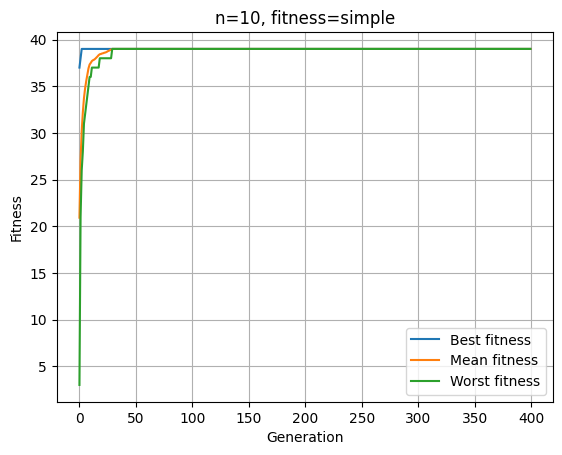

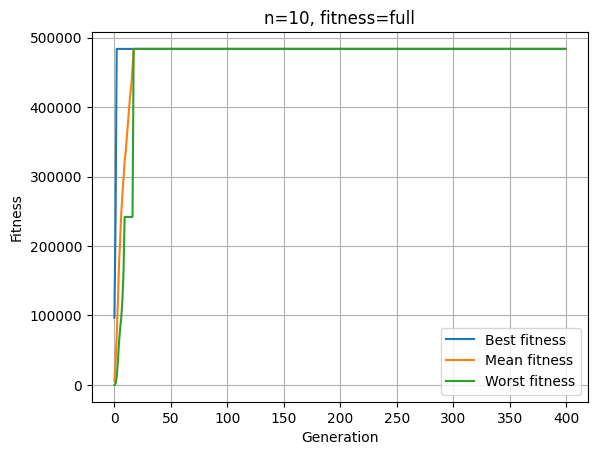

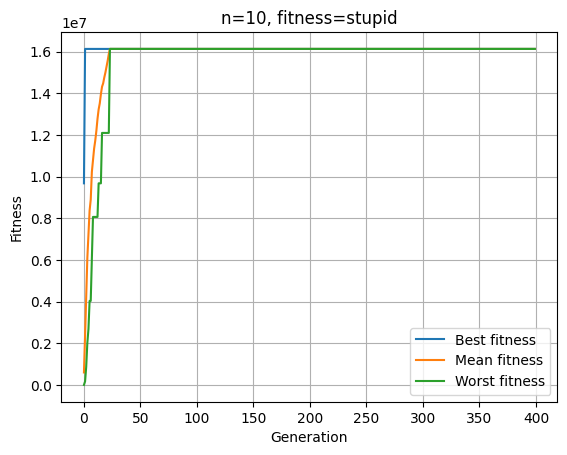

In [ ]:
n = 10
weights, values = load_knapsack_dataset(n)
capacity = capacities[n]

pop_size = 100
Pc = 0.8
Pm = 0.2
max_generations = 400  # طبق صورت سؤال

for f_type in fitness_types:
    result = run_ea_knapsack(
        weights, values, capacity,
        pop_size=pop_size,
        max_generations=max_generations,
        Pc=Pc,
        Pm=Pm,
        fitness_type=f_type,
        ignore_capacity_for_full=True,  # طبق صورت سؤال
        random_seed=0
    )

    plot_evolution(
        result["best_history"],
        result["worst_history"],
        result["mean_history"],
        title=f"n={n}, fitness={f_type}"
    )


### 2-
حداقل ۶ اجرای مختلف و نمودار میانگین و انحراف معیار متوسط برازندگی در هر نسل

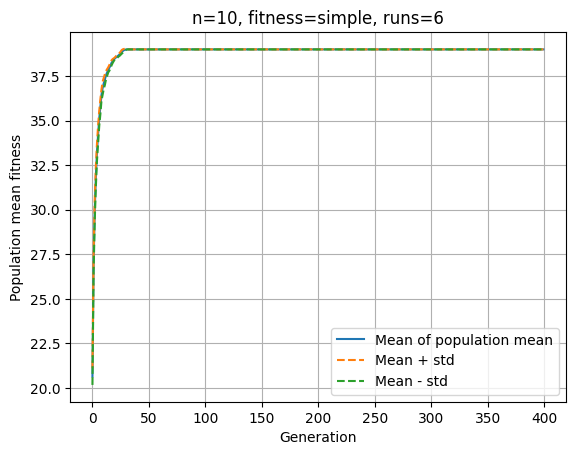

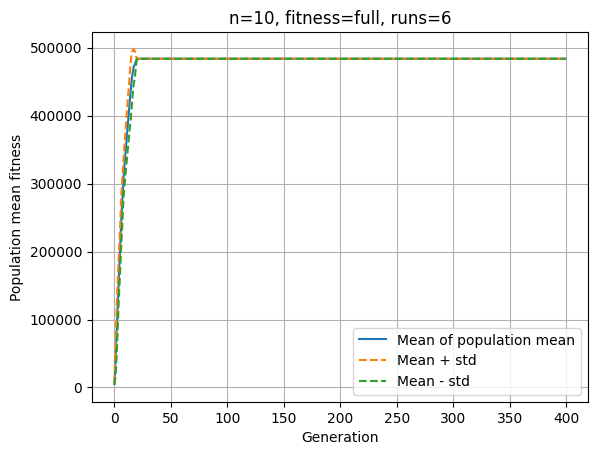

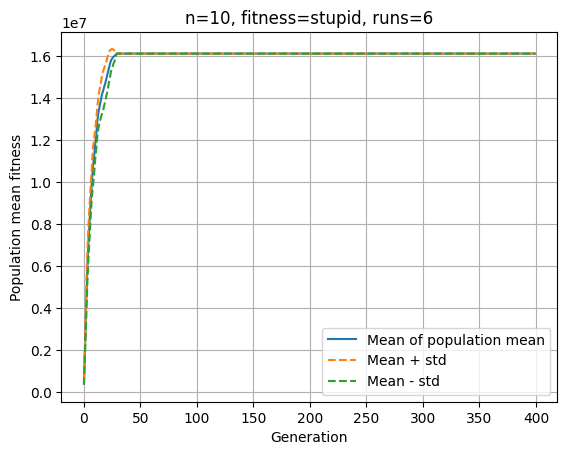

In [ ]:
def experiment_multi_runs(n, f_type,
                          runs=6,
                          pop_size=100,
                          Pc=0.8,
                          Pm=0.2,
                          max_generations=400):
    weights, values = load_knapsack_dataset(n)
    capacity = capacities[n]

    all_mean_histories = []

    for r in range(runs):
        res = run_ea_knapsack(
            weights, values, capacity,
            pop_size=pop_size,
            max_generations=max_generations,
            Pc=Pc,
            Pm=Pm,
            fitness_type=f_type,
            ignore_capacity_for_full=True,
            random_seed=r  # برای تکرارپذیری
        )
        all_mean_histories.append(res["mean_history"])

    all_mean_histories = np.array(all_mean_histories)  # how? : (runs, generations)

    mean_over_runs = np.mean(all_mean_histories, axis=0)
    std_over_runs = np.std(all_mean_histories, axis=0)

    generations = np.arange(max_generations)

    plt.figure()
    plt.plot(generations, mean_over_runs, label="Mean of population mean")
    plt.plot(generations, mean_over_runs + std_over_runs, linestyle='--',
             label="Mean + std")
    plt.plot(generations, mean_over_runs - std_over_runs, linestyle='--',
             label="Mean - std")
    plt.xlabel("Generation")
    plt.ylabel("Population mean fitness")
    plt.title(f"n={n}, fitness={f_type}, runs={runs}")
    plt.legend()
    plt.grid(True)
    plt.show()

    return mean_over_runs, std_over_runs

# n=10  هر سه تابع برازندگی
for f_type in fitness_types:
    experiment_multi_runs(10, f_type)


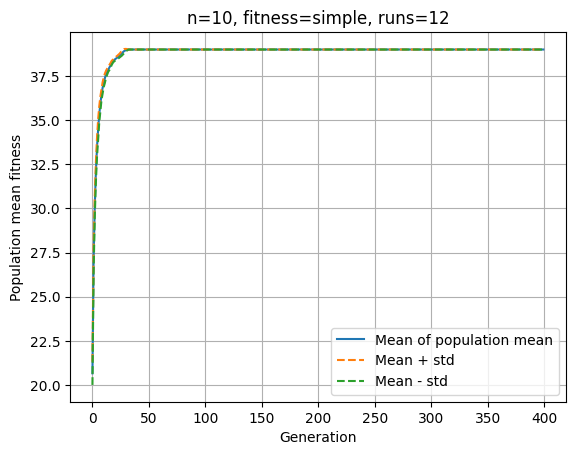

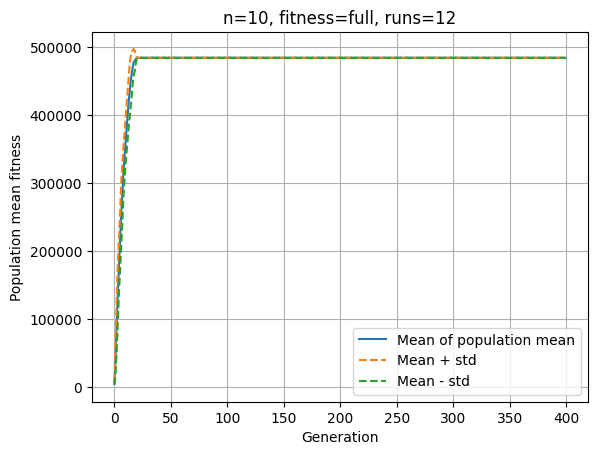

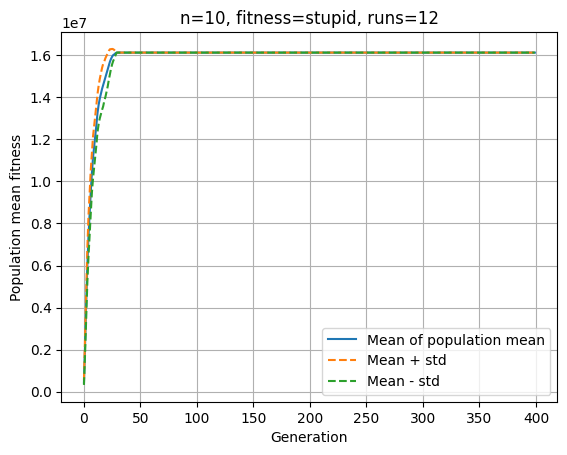

In [ ]:
def experiment_multi_runs(n, f_type,
                          runs=12,
                          pop_size=100,
                          Pc=0.8,
                          Pm=0.2,
                          max_generations=400):
    weights, values = load_knapsack_dataset(n)
    capacity = capacities[n]

    all_mean_histories = []

    for r in range(runs):
        res = run_ea_knapsack(
            weights, values, capacity,
            pop_size=pop_size,
            max_generations=max_generations,
            Pc=Pc,
            Pm=Pm,
            fitness_type=f_type,
            ignore_capacity_for_full=True,
            random_seed=r  # برای تکرارپذیری
        )
        all_mean_histories.append(res["mean_history"])

    all_mean_histories = np.array(all_mean_histories)  # how? : (runs, generations)

    mean_over_runs = np.mean(all_mean_histories, axis=0)
    std_over_runs = np.std(all_mean_histories, axis=0)

    generations = np.arange(max_generations)

    plt.figure()
    plt.plot(generations, mean_over_runs, label="Mean of population mean")
    plt.plot(generations, mean_over_runs + std_over_runs, linestyle='--',
             label="Mean + std")
    plt.plot(generations, mean_over_runs - std_over_runs, linestyle='--',
             label="Mean - std")
    plt.xlabel("Generation")
    plt.ylabel("Population mean fitness")
    plt.title(f"n={n}, fitness={f_type}, runs={runs}")
    plt.legend()
    plt.grid(True)
    plt.show()

    return mean_over_runs, std_over_runs

# n=10  هر سه تابع برازندگی
for f_type in fitness_types:
    experiment_multi_runs(10, f_type)


### 3-
تأثیر اندازه مسئله (n = 10, 20, 60, 100)

نمودار میانگین و انحراف معیار عملکرد (میانگین برازندگی جمعیت نهایی) بر حسب اندازه مسئله

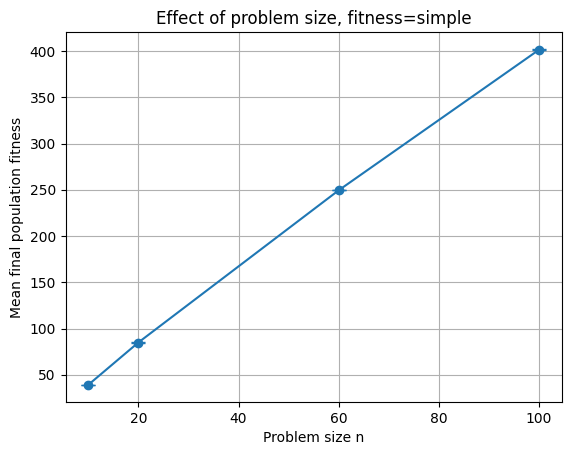

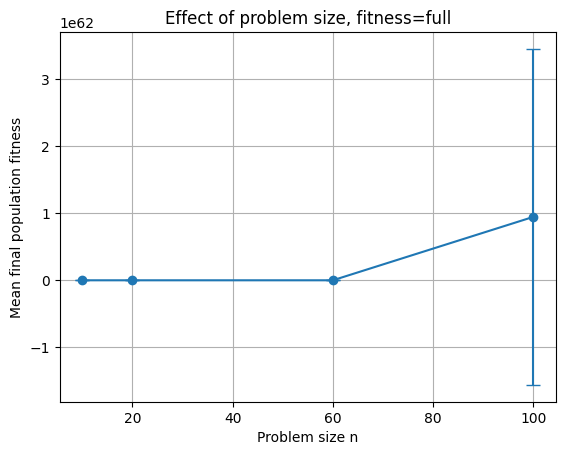

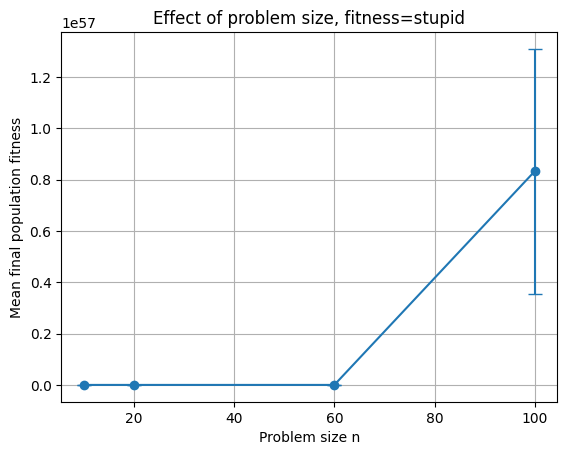

In [ ]:
def experiment_problem_sizes(f_type,
                             ns=(10, 20, 60, 100),
                             runs=10,
                             pop_size=100,
                             Pc=0.8,
                             Pm=0.2,
                             max_generations=400):
    mean_performance = []
    std_performance = []

    for n in ns:
        weights, values = load_knapsack_dataset(n)
        capacity = capacities[n]

        final_means = []
        for r in range(runs):
            res = run_ea_knapsack(
                weights, values, capacity,
                pop_size=pop_size,
                max_generations=max_generations,
                Pc=Pc,
                Pm=Pm,
                fitness_type=f_type,
                ignore_capacity_for_full=True,
                random_seed=r
            )
            final_means.append(np.mean(res["final_fitnesses"]))

        mean_performance.append(mean(final_means))
        std_performance.append(stdev(final_means))

    # نمودار
    plt.figure()
    plt.errorbar(ns, mean_performance, yerr=std_performance,
                 fmt='o-', capsize=5)
    plt.xlabel("Problem size n")
    plt.ylabel("Mean final population fitness")
    plt.title(f"Effect of problem size, fitness={f_type}")
    plt.grid(True)
    plt.show()

    return mean_performance, std_performance

for f_type in fitness_types:
    experiment_problem_sizes(f_type)


### 4-
تأثیر تعداد تکرارهای حلقه (Max Generations)

مقادیر خواسته‌شده:
{50,100,200,300}

برای هر ان یک نمودار جدا و برای هر تابع برازندگی قابل اجراست.


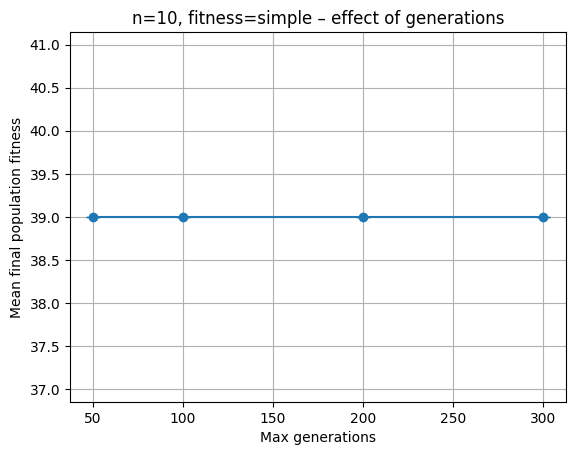

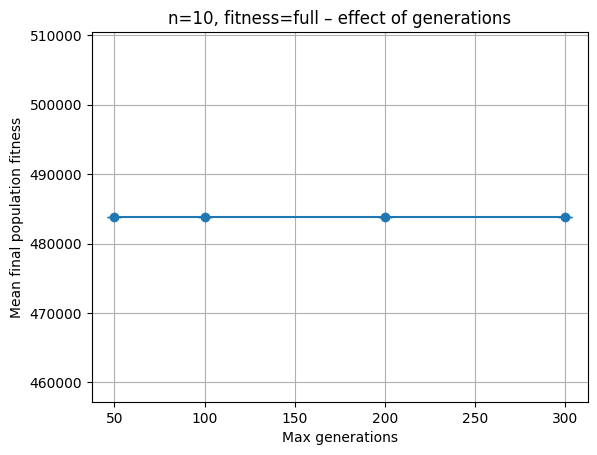

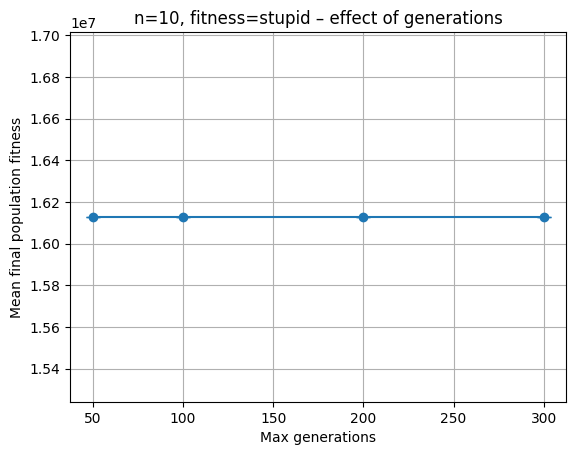

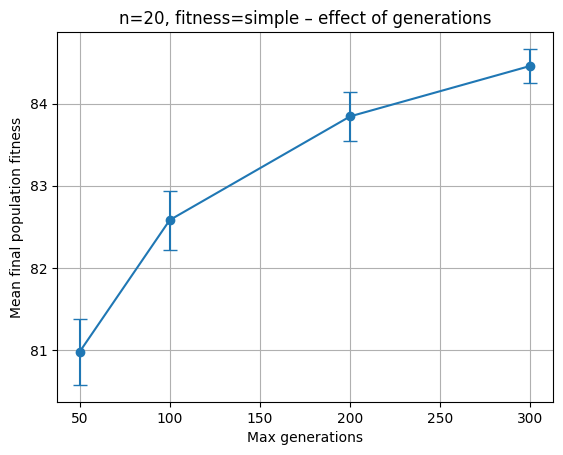

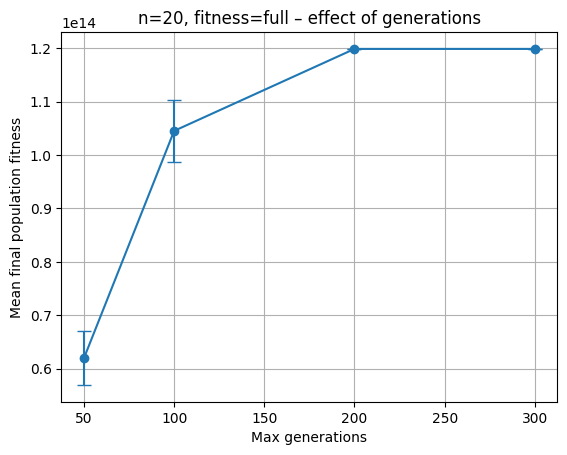

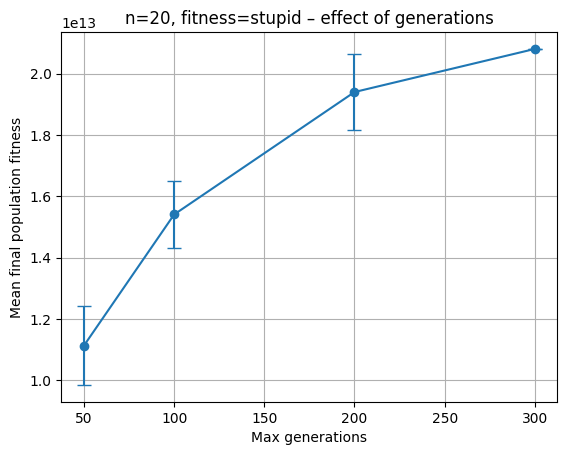

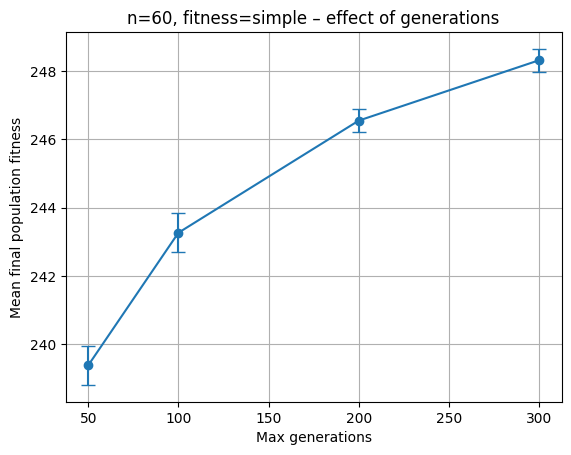

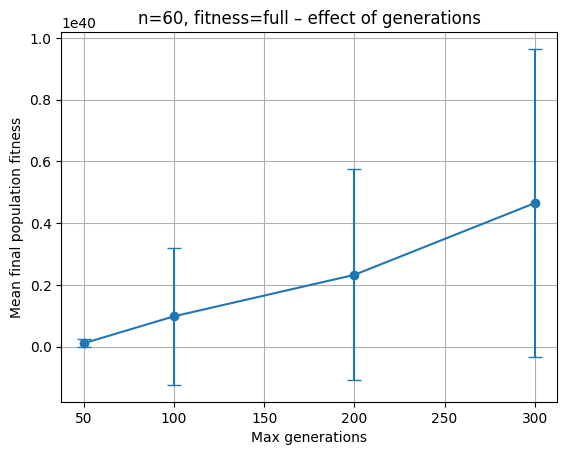

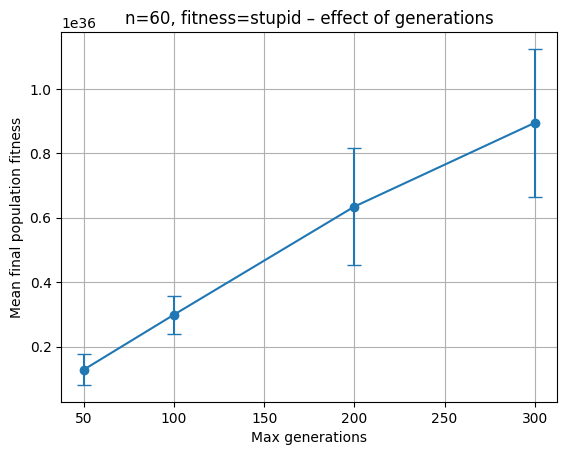

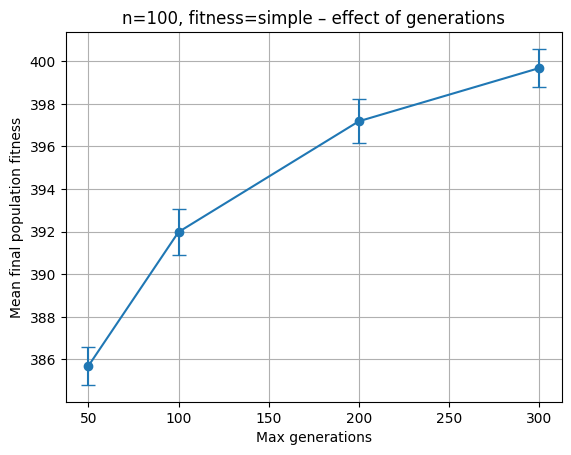

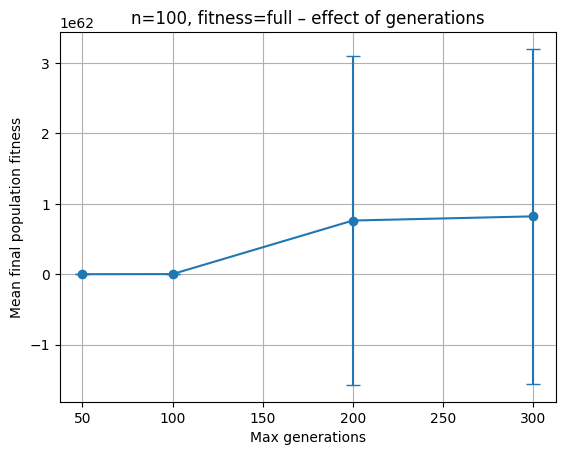

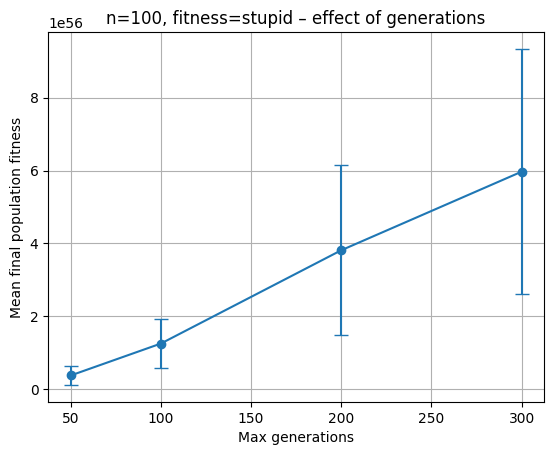

In [ ]:
def experiment_generations(n, f_type,
                           generations_list=(50, 100, 200, 300),
                           runs=10,
                           pop_size=100,
                           Pc=0.8,
                           Pm=0.2):
    weights, values = load_knapsack_dataset(n)
    capacity = capacities[n]

    means = []
    stds = []

    for max_gen in generations_list:
        finals = []
        for r in range(runs):
            res = run_ea_knapsack(
                weights, values, capacity,
                pop_size=pop_size,
                max_generations=max_gen,
                Pc=Pc,
                Pm=Pm,
                fitness_type=f_type,
                ignore_capacity_for_full=True,
                random_seed=r
            )
            finals.append(np.mean(res["final_fitnesses"]))
        means.append(mean(finals))
        stds.append(stdev(finals))

    plt.figure()
    plt.errorbar(generations_list, means, yerr=stds,
                 fmt='o-', capsize=5)
    plt.xlabel("Max generations")
    plt.ylabel("Mean final population fitness")
    plt.title(f"n={n}, fitness={f_type} – effect of generations")
    plt.grid(True)
    plt.show()


for n in (10, 20, 60, 100):
    for f_type in fitness_types:
        experiment_generations(n, f_type)


### 5-
تأثیر اندازه جمعیت (popSize ∈ {50, 100, 200, 300})

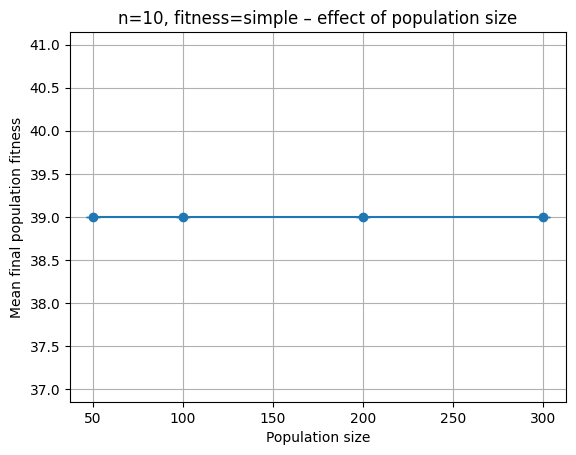

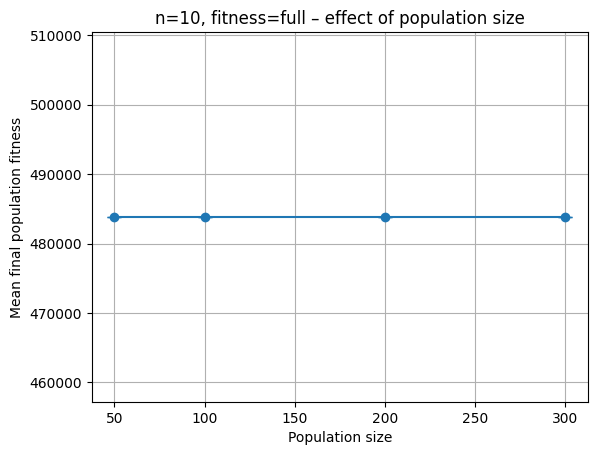

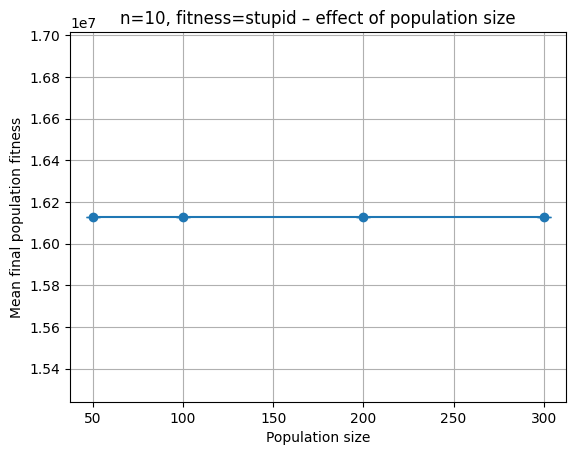

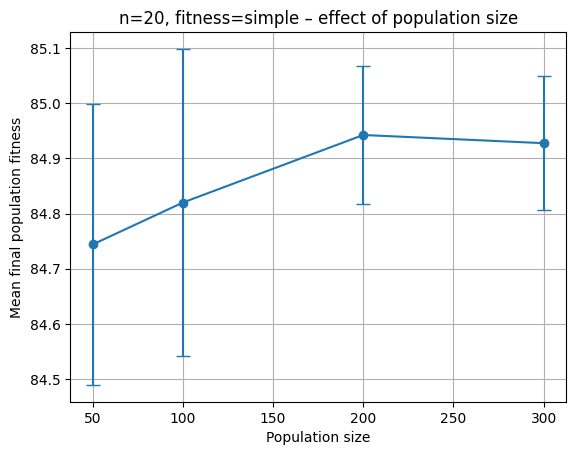

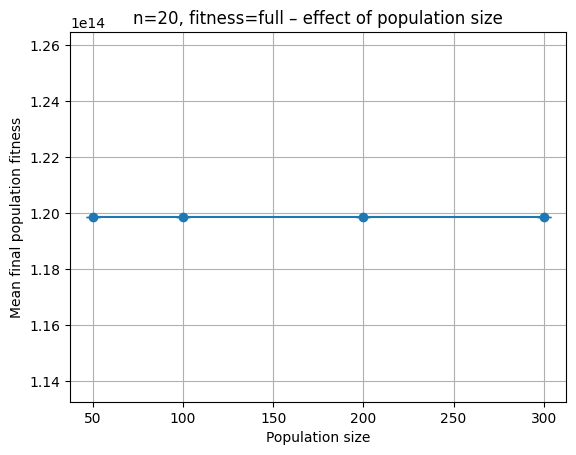

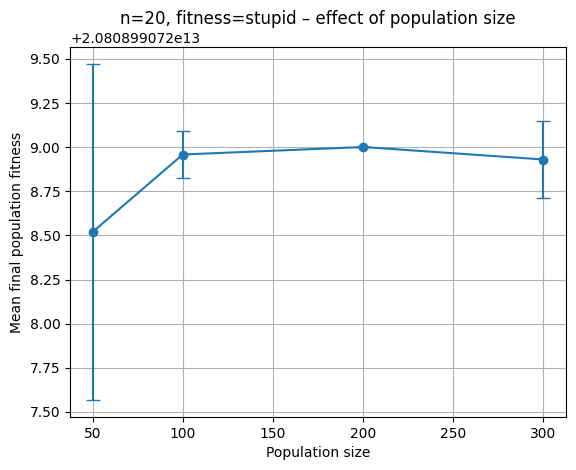

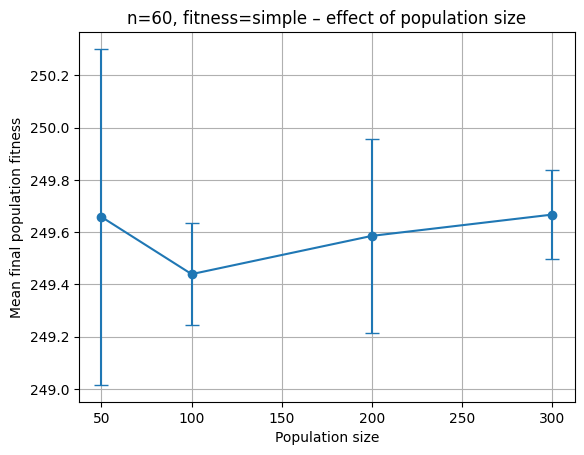

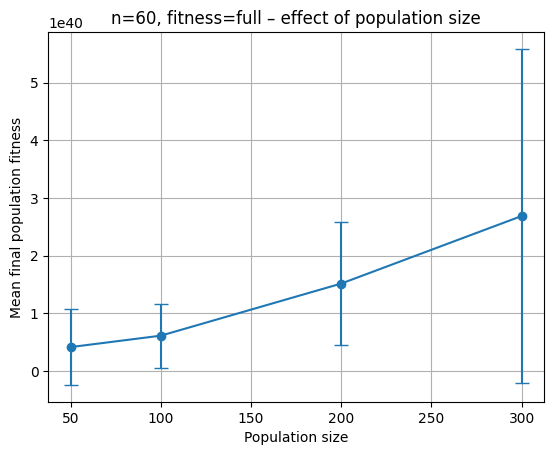

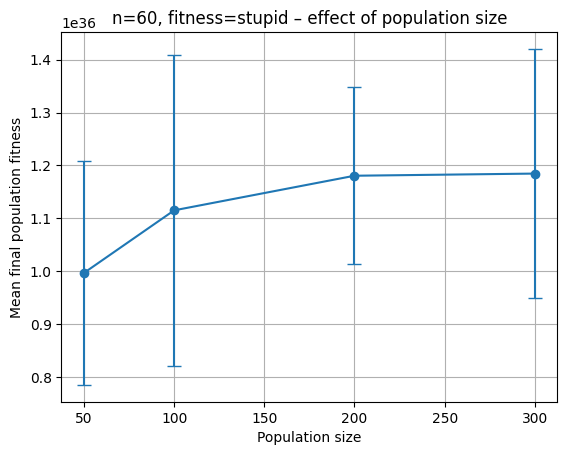

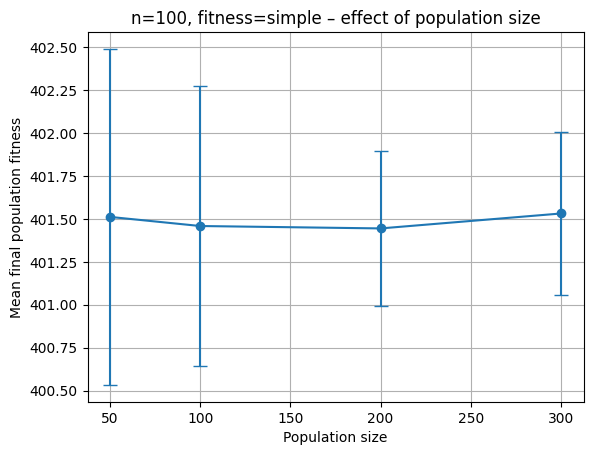

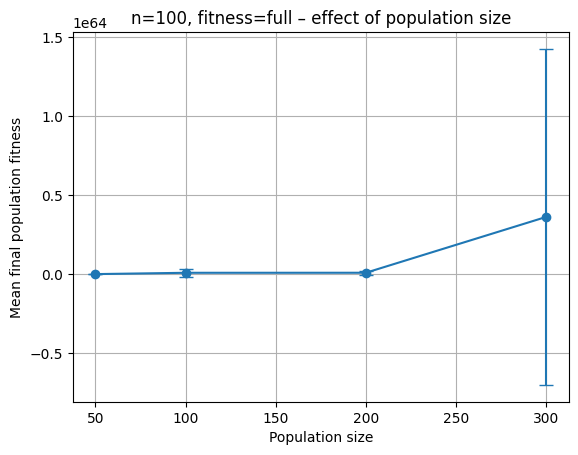

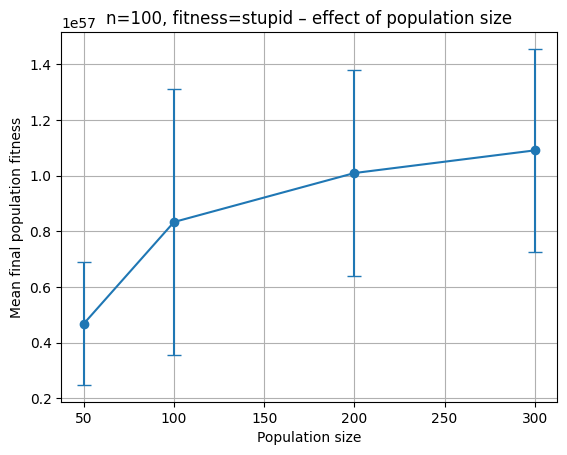

In [11]:
def experiment_population_size(n, f_type,
                               pop_sizes=(50, 100, 200, 300),
                               runs=10,
                               Pc=0.8,
                               Pm=0.2,
                               max_generations=400):
    weights, values = load_knapsack_dataset(n)
    capacity = capacities[n]

    means = []
    stds = []

    for pop_size in pop_sizes:
        finals = []
        for r in range(runs):
            res = run_ea_knapsack(
                weights, values, capacity,
                pop_size=pop_size,
                max_generations=max_generations,
                Pc=Pc,
                Pm=Pm,
                fitness_type=f_type,
                ignore_capacity_for_full=True,
                random_seed=r
            )
            finals.append(np.mean(res["final_fitnesses"]))
        means.append(mean(finals))
        stds.append(stdev(finals))

    plt.figure()
    plt.errorbar(pop_sizes, means, yerr=stds,
                 fmt='o-', capsize=5)
    plt.xlabel("Population size")
    plt.ylabel("Mean final population fitness")
    plt.title(f"n={n}, fitness={f_type} – effect of population size")
    plt.grid(True)
    plt.show()

for n in (10, 20, 60, 100):
    for f_type in fitness_types:
        experiment_population_size(n, f_type)


### 6-
تأثیر احتمال بازترکیب

Pc ∈ {0.6,0.7,0.9,1}


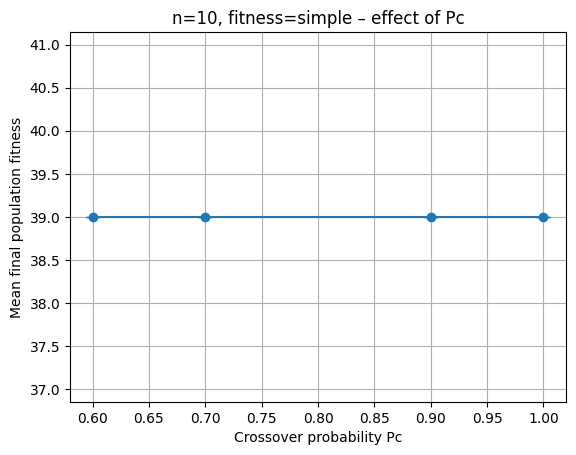

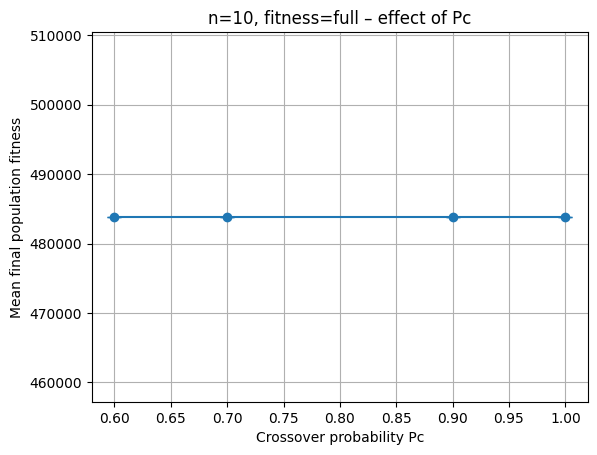

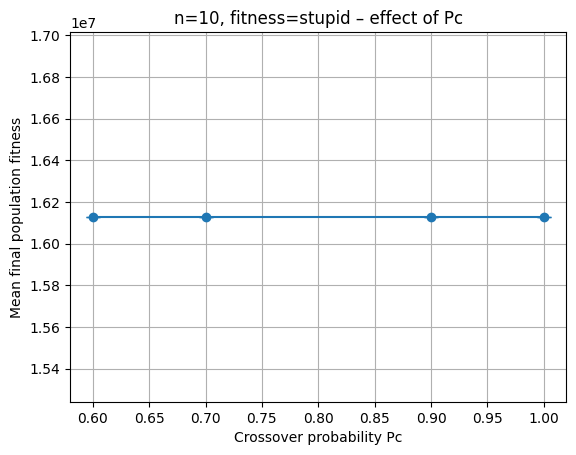

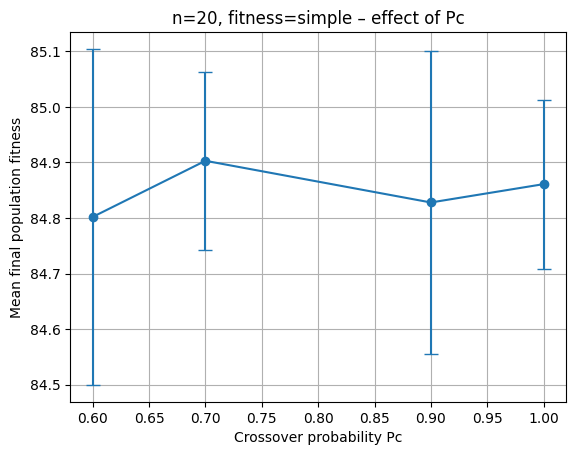

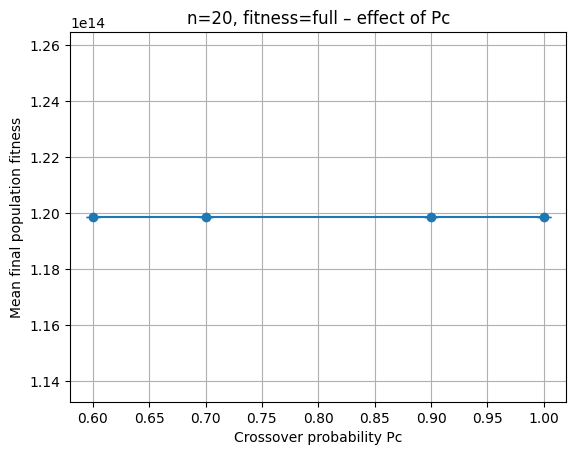

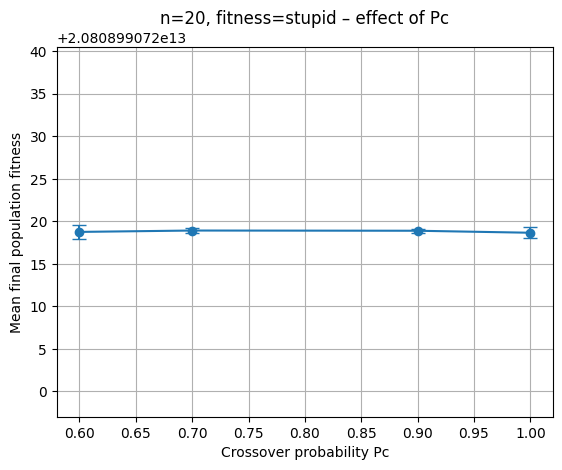

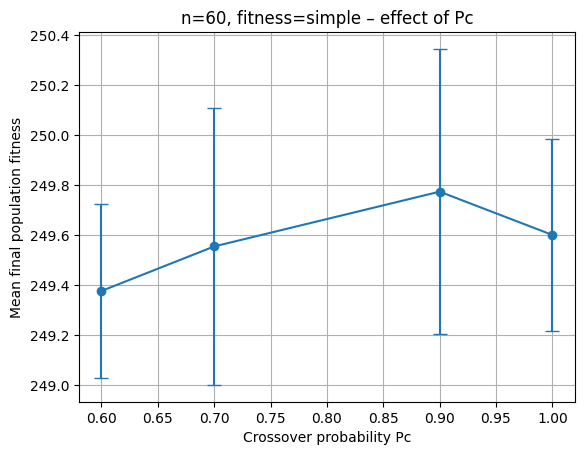

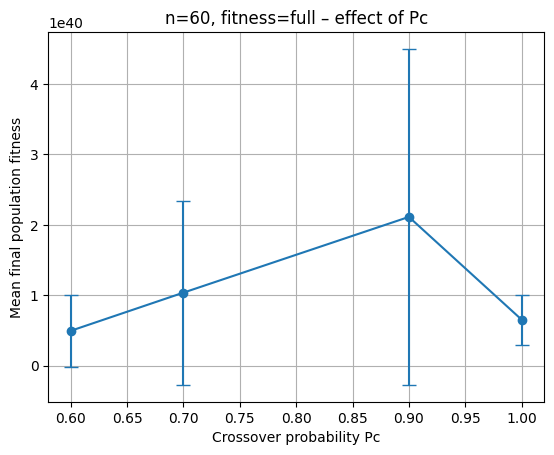

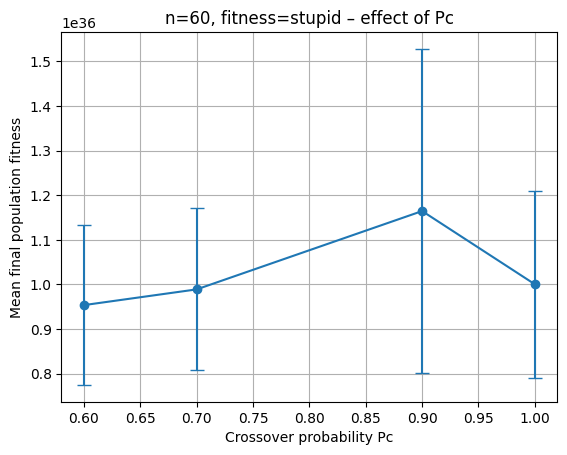

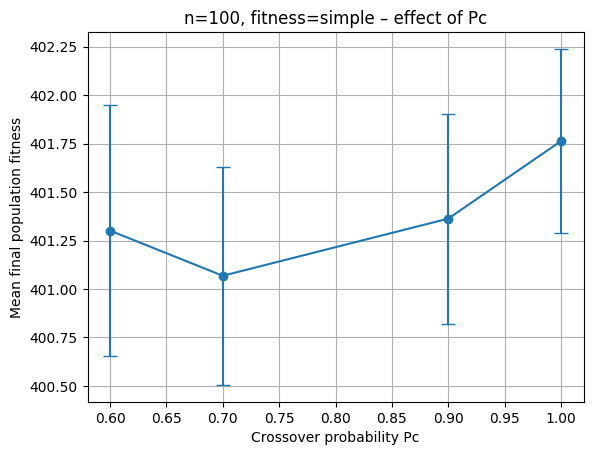

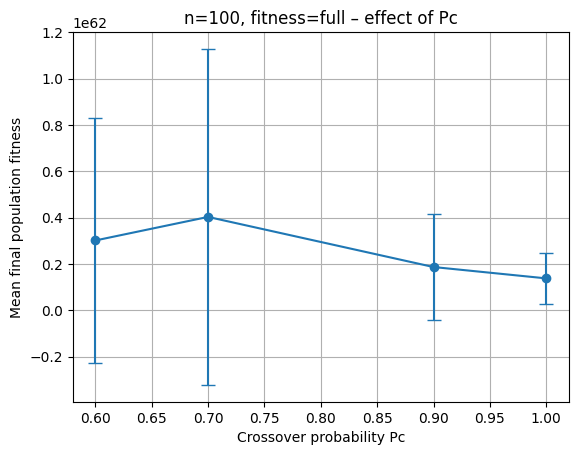

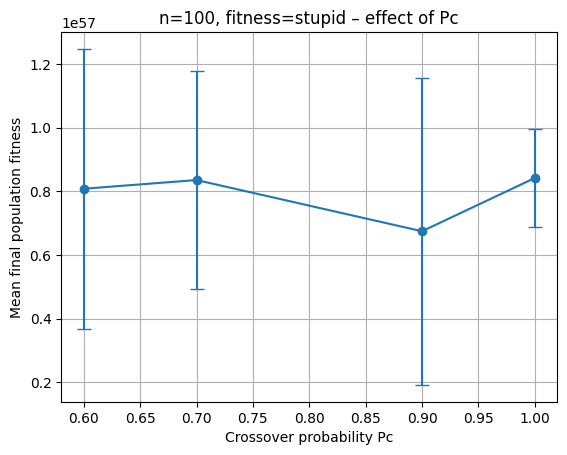

In [12]:
def experiment_crossover_prob(n, f_type,
                              Pc_list=(0.6, 0.7, 0.9, 1.0),
                              runs=10,
                              pop_size=100,
                              Pm=0.2,
                              max_generations=400):
    weights, values = load_knapsack_dataset(n)
    capacity = capacities[n]

    means = []
    stds = []

    for Pc in Pc_list:
        finals = []
        for r in range(runs):
            res = run_ea_knapsack(
                weights, values, capacity,
                pop_size=pop_size,
                max_generations=max_generations,
                Pc=Pc,
                Pm=Pm,
                fitness_type=f_type,
                ignore_capacity_for_full=True,
                random_seed=r
            )
            finals.append(np.mean(res["final_fitnesses"]))
        means.append(mean(finals))
        stds.append(stdev(finals))

    plt.figure()
    plt.errorbar(Pc_list, means, yerr=stds,
                 fmt='o-', capsize=5)
    plt.xlabel("Crossover probability Pc")
    plt.ylabel("Mean final population fitness")
    plt.title(f"n={n}, fitness={f_type} – effect of Pc")
    plt.grid(True)
    plt.show()


for n in (10, 20, 60, 100):
    for f_type in fitness_types:
        experiment_crossover_prob(n, f_type)


### 7-
تأثیر احتمال جهش

Pm ∈ {0.05,0.1,0.3,0.5}

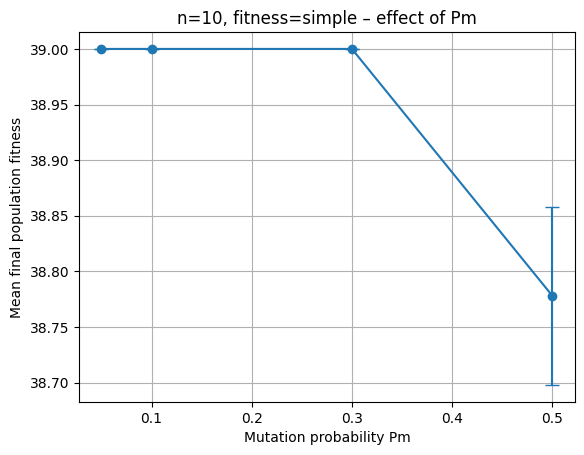

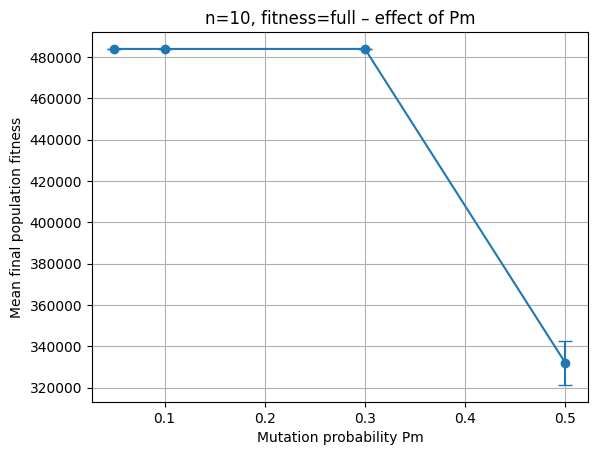

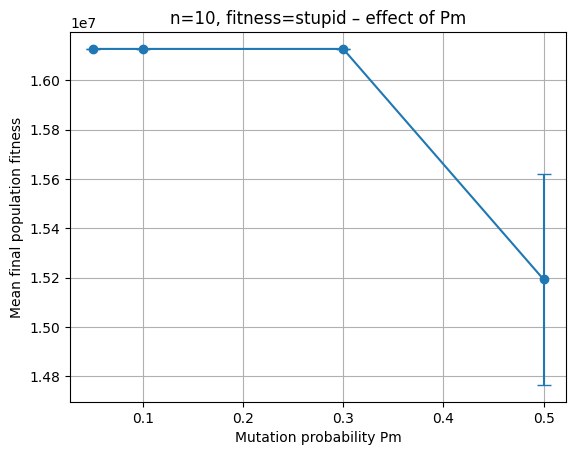

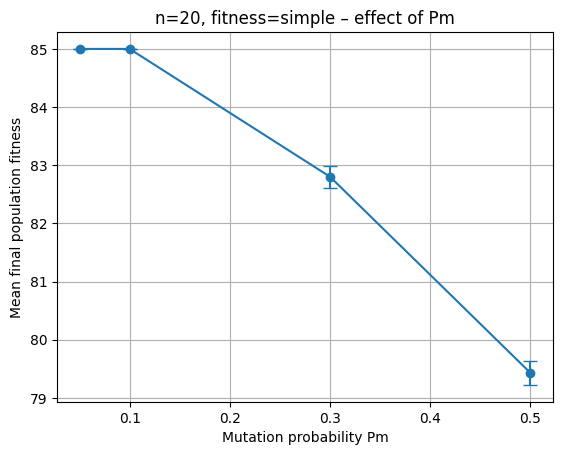

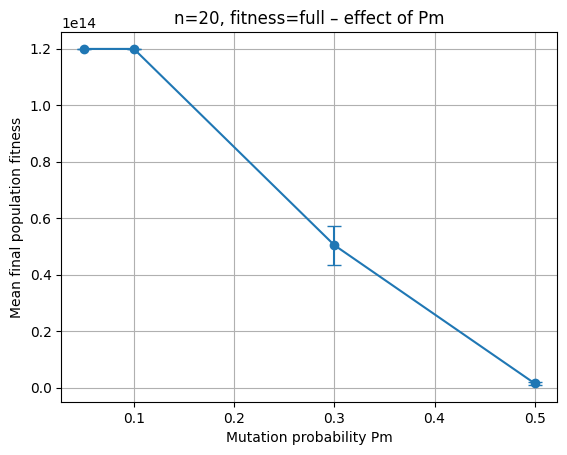

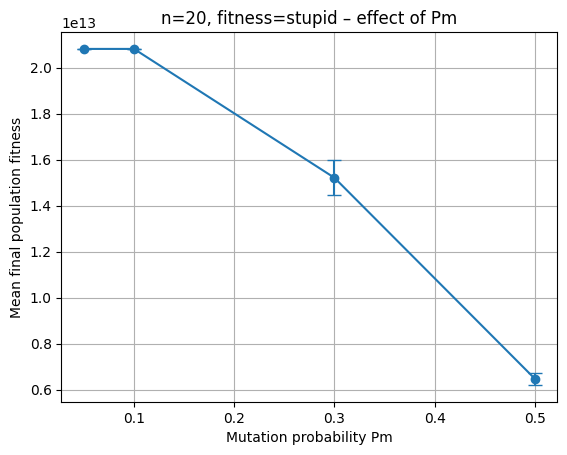

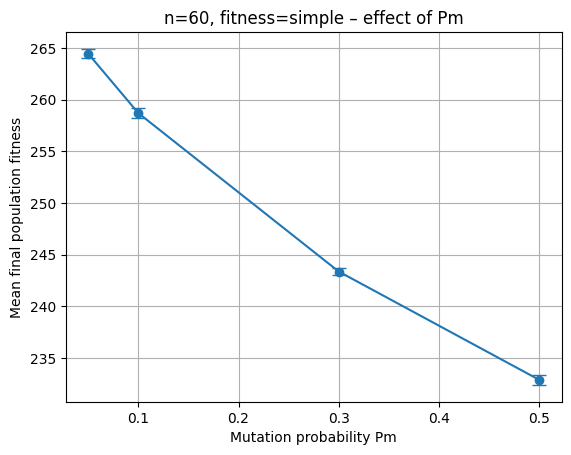

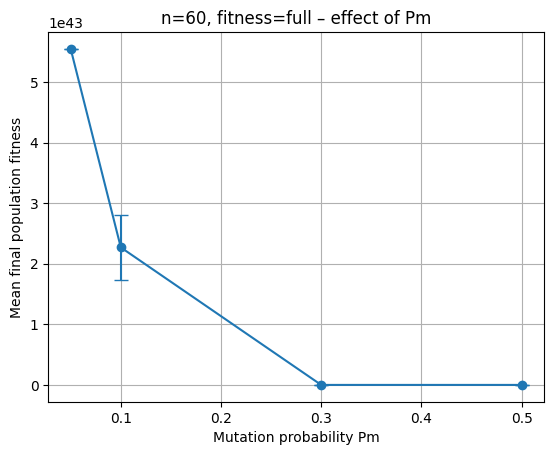

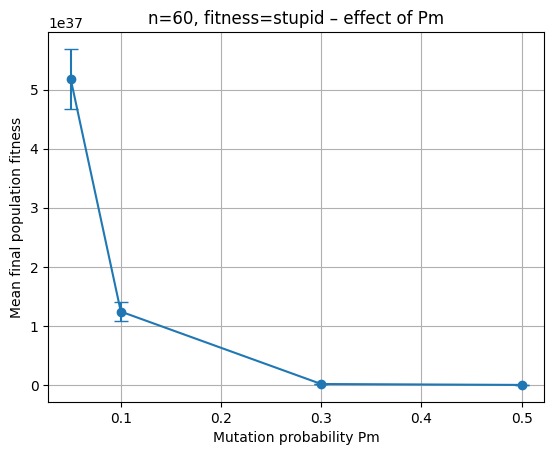

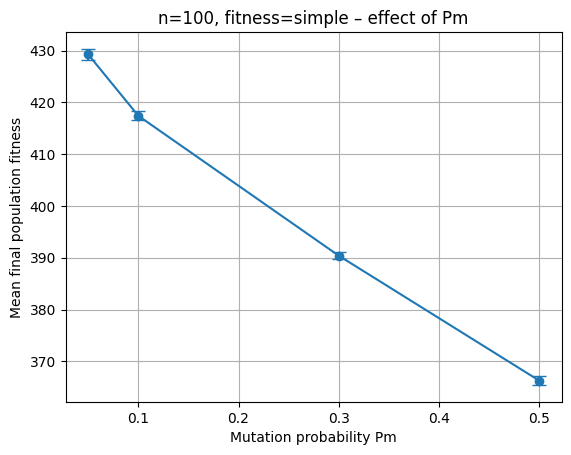

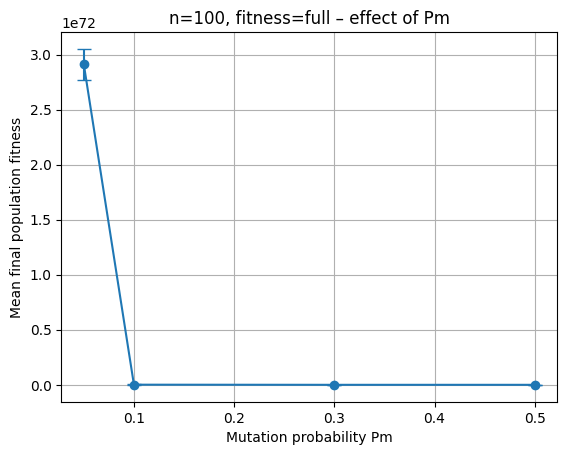

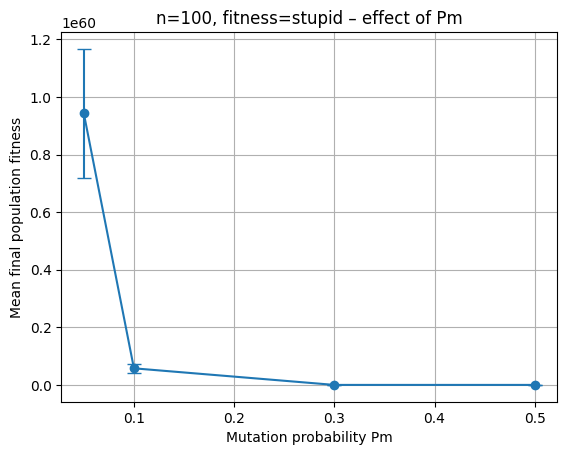

In [13]:
def experiment_mutation_prob(n, f_type,
                             Pm_list=(0.05, 0.1, 0.3, 0.5),
                             runs=10,
                             pop_size=100,
                             Pc=0.8,
                             max_generations=400):
    weights, values = load_knapsack_dataset(n)
    capacity = capacities[n]

    means = []
    stds = []

    for Pm in Pm_list:
        finals = []
        for r in range(runs):
            res = run_ea_knapsack(
                weights, values, capacity,
                pop_size=pop_size,
                max_generations=max_generations,
                Pc=Pc,
                Pm=Pm,
                fitness_type=f_type,
                ignore_capacity_for_full=True,
                random_seed=r
            )
            finals.append(np.mean(res["final_fitnesses"]))
        means.append(mean(finals))
        stds.append(stdev(finals))

    plt.figure()
    plt.errorbar(Pm_list, means, yerr=stds,
                 fmt='o-', capsize=5)
    plt.xlabel("Mutation probability Pm")
    plt.ylabel("Mean final population fitness")
    plt.title(f"n={n}, fitness={f_type} – effect of Pm")
    plt.grid(True)
    plt.show()

for n in (10, 20, 60, 100):
    for f_type in fitness_types:
        experiment_mutation_prob(n, f_type)


### 8-
بهترین راه‌حل در اینجا، کروموزوم دودویی‌ای است که بیشترین برازندگی را در پایان هر اجرا داشته است .

In [14]:
def show_best_solution(result, weights, values, capacity,
                       fitness_type='simple',
                       ignore_capacity_for_full=True):
    final_pop = result["final_population"]
    final_fit = result["final_fitnesses"]

    idx_best = np.argmax(final_fit)
    x_best = final_pop[idx_best]
    fit_best = final_fit[idx_best]

    total_weight = np.dot(x_best, weights)
    total_value  = np.dot(x_best, values)


    check_fit = evaluate_population(
        np.array([x_best]),
        weights,
        values,
        capacity,
        fitness_type,
        ignore_capacity_for_full
    )[0]

    print("Best chromosome     :", x_best)
    print("Total weight        :", total_weight)
    print("Total value         :", total_value)
    print("Recorded fitness    :", fit_best)
    print("Recomputed fitness  :", check_fit)

In [15]:
n = 10
weights, values = load_knapsack_dataset(n)
capacity = capacities[n]

res_simple = run_ea_knapsack(
    weights, values, capacity,
    pop_size=100,
    max_generations=400,
    Pc=0.8,
    Pm=0.2,
    fitness_type='simple',
    ignore_capacity_for_full=True,
    random_seed=0
)

show_best_solution(res_simple, weights, values, capacity, fitness_type='simple')

Best chromosome     : [1 1 1 1 1 1 1 1 0 1]
Total weight        : 22.0
Total value         : 39.0
Recorded fitness    : 39.0
Recomputed fitness  : 39.0


In [28]:
n = 10
weights, values = load_knapsack_dataset(n)
capacity = capacities[n]

res_simple = run_ea_knapsack(
    weights, values, capacity,
    pop_size=100,
    max_generations=400,
    Pc=0.8,
    Pm=0.2,
    fitness_type='full',
    ignore_capacity_for_full=True,
    random_seed=0
)

show_best_solution(res_simple, weights, values, capacity, fitness_type='full')

Best chromosome     : [1 1 1 1 1 1 1 1 1 1]
Total weight        : 24.0
Total value         : 42.0
Recorded fitness    : 483840.0
Recomputed fitness  : 483840.0


In [29]:
n = 10
weights, values = load_knapsack_dataset(n)
capacity = capacities[n]

res_simple = run_ea_knapsack(
    weights, values, capacity,
    pop_size=100,
    max_generations=400,
    Pc=0.8,
    Pm=0.2,
    fitness_type='stupid',
    ignore_capacity_for_full=True,
    random_seed=0
)

show_best_solution(res_simple, weights, values, capacity, fitness_type='stupid')

Best chromosome     : [1 1 1 1 1 1 1 1 0 1]
Total weight        : 22.0
Total value         : 39.0
Recorded fitness    : 16127961.0
Recomputed fitness  : 16127961.0


In [16]:
n = 20
weights, values = load_knapsack_dataset(n)
capacity = capacities[n]

res_simple = run_ea_knapsack(
    weights, values, capacity,
    pop_size=100,
    max_generations=400,
    Pc=0.8,
    Pm=0.2,
    fitness_type='simple',
    ignore_capacity_for_full=True,
    random_seed=0
)

show_best_solution(res_simple, weights, values, capacity, fitness_type='simple')

Best chromosome     : [1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 1]
Total weight        : 39.0
Total value         : 85.0
Recorded fitness    : 85.0
Recomputed fitness  : 85.0


In [30]:
n = 20
weights, values = load_knapsack_dataset(n)
capacity = capacities[n]

res_simple = run_ea_knapsack(
    weights, values, capacity,
    pop_size=100,
    max_generations=400,
    Pc=0.8,
    Pm=0.2,
    fitness_type='full',
    ignore_capacity_for_full=True,
    random_seed=0
)

show_best_solution(res_simple, weights, values, capacity, fitness_type='full')

Best chromosome     : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Total weight        : 57.0
Total value         : 109.0
Recorded fitness    : 119859786547200.0
Recomputed fitness  : 119859786547200.0


In [31]:
n = 20
weights, values = load_knapsack_dataset(n)
capacity = capacities[n]

res_simple = run_ea_knapsack(
    weights, values, capacity,
    pop_size=100,
    max_generations=400,
    Pc=0.8,
    Pm=0.2,
    fitness_type='stupid',
    ignore_capacity_for_full=True,
    random_seed=0
)

show_best_solution(res_simple, weights, values, capacity, fitness_type='stupid')

Best chromosome     : [1 1 1 1 0 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1]
Total weight        : 39.0
Total value         : 81.0
Recorded fitness    : 20808990719919.0
Recomputed fitness  : 20808990719919.0


In [17]:
n = 60
weights, values = load_knapsack_dataset(n)
capacity = capacities[n]

res_simple = run_ea_knapsack(
    weights, values, capacity,
    pop_size=100,
    max_generations=400,
    Pc=0.8,
    Pm=0.2,
    fitness_type='simple',
    ignore_capacity_for_full=True,
    random_seed=0
)

show_best_solution(res_simple, weights, values, capacity, fitness_type='simple')

Best chromosome     : [1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 1 1 0 1 0 0 1 1 0 1 1 1 0 1 1 1
 1 0 1 0 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1]
Total weight        : 130.0
Total value         : 254.0
Recorded fitness    : 254.0
Recomputed fitness  : 254.0


In [32]:
n = 60
weights, values = load_knapsack_dataset(n)
capacity = capacities[n]

res_simple = run_ea_knapsack(
    weights, values, capacity,
    pop_size=100,
    max_generations=400,
    Pc=0.8,
    Pm=0.2,
    fitness_type='full',
    ignore_capacity_for_full=True,
    random_seed=0
)

show_best_solution(res_simple, weights, values, capacity, fitness_type='full')

Best chromosome     : [1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Total weight        : 181.0
Total value         : 325.0
Recorded fitness    : 5.282833234576835e+41
Recomputed fitness  : 5.282833234576835e+41


In [33]:
n = 60
weights, values = load_knapsack_dataset(n)
capacity = capacities[n]

res_simple = run_ea_knapsack(
    weights, values, capacity,
    pop_size=100,
    max_generations=400,
    Pc=0.8,
    Pm=0.2,
    fitness_type='stupid',
    ignore_capacity_for_full=True,
    random_seed=0
)

show_best_solution(res_simple, weights, values, capacity, fitness_type='stupid')

Best chromosome     : [1 1 1 0 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1
 1 1 1 0 0 1 0 1 1 1 0 1 1 1 0 1 0 0 1 0 1 1 1]
Total weight        : 130.0
Total value         : 257.0
Recorded fitness    : 3.929042389017102e+36
Recomputed fitness  : 3.929042389017102e+36


In [18]:
n = 100
weights, values = load_knapsack_dataset(n)
capacity = capacities[n]

res_simple = run_ea_knapsack(
    weights, values, capacity,
    pop_size=100,
    max_generations=400,
    Pc=0.8,
    Pm=0.2,
    fitness_type='simple',
    ignore_capacity_for_full=True,
    random_seed=0
)

show_best_solution(res_simple, weights, values, capacity, fitness_type='simple')

Best chromosome     : [1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 0 0 1 0 1 1 1 1 1 0 0 0 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0
 0 1 1 0 1 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1]
Total weight        : 213.0
Total value         : 410.0
Recorded fitness    : 410.0
Recomputed fitness  : 410.0


In [34]:
n = 100
weights, values = load_knapsack_dataset(n)
capacity = capacities[n]

res_simple = run_ea_knapsack(
    weights, values, capacity,
    pop_size=100,
    max_generations=400,
    Pc=0.8,
    Pm=0.2,
    fitness_type='full',
    ignore_capacity_for_full=True,
    random_seed=0
)

show_best_solution(res_simple, weights, values, capacity, fitness_type='full')

Best chromosome     : [1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
Total weight        : 264.0
Total value         : 478.0
Recorded fitness    : 2.358311908694068e+62
Recomputed fitness  : 2.358311908694068e+62


In [35]:
n = 100
weights, values = load_knapsack_dataset(n)
capacity = capacities[n]

res_simple = run_ea_knapsack(
    weights, values, capacity,
    pop_size=100,
    max_generations=400,
    Pc=0.8,
    Pm=0.2,
    fitness_type='stupid',
    ignore_capacity_for_full=True,
    random_seed=0
)

show_best_solution(res_simple, weights, values, capacity, fitness_type='stupid')

Best chromosome     : [0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 1 1 0 1 0 1 0 1 1 1 1 1
 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 0 1 1 0 1 1 1 1 1 0]
Total weight        : 213.0
Total value         : 412.0
Recorded fitness    : 6.93213377041172e+57
Recomputed fitness  : 6.93213377041172e+57


### 9-
تورنومنت

In [36]:
def tournament_selection(pop, fitnesses, num_selected, k=2, with_replacement=True):
    """
    انتخاب با رقابت دودویی:
    - هر بار k فرد به‌طور تصادفی انتخاب می‌شود.
    - فردی که بیشترین برازندگی را دارد برنده می‌شود.
    - این کار را تا انتخاب num_selected والد تکرار می‌کنیم.
    اگر with_replacement=True باشد، افراد می‌توانند چند بار در تورنمنت‌ها شرکت کنند.
    """
    pop_size = len(pop)
    selected = []

    for _ in range(num_selected):
        # انتخاب کا فرد (با جایگزینی)
        indices = np.random.randint(0, pop_size, size=k)
        best_idx = indices[0]
        best_fit = fitnesses[indices[0]]

        for idx in indices[1:]:
            if fitnesses[idx] > best_fit:
                best_fit = fitnesses[idx]
                best_idx = idx

        selected.append(pop[best_idx].copy())

    return np.array(selected)

In [ ]:
pop_size = 200
max_generations = 200
Pc = 0.9
Pm = 0.1

In [38]:
def run_ea_knapsack_sel_cx(weights, values, capacity,
                           pop_size=100,
                           max_generations=400,
                           Pc=0.8,
                           Pm=0.2,
                           fitness_type='simple',
                           ignore_capacity_for_full=True,
                           selection_method='roulette',  # 'roulette' یا 'tournament'
                           tournament_k=2,
                           random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)
        random.seed(random_seed)

    n = len(weights)
    pop = np.random.randint(0, 2, size=(pop_size, n))

    best_history = []
    worst_history = []
    mean_history = []

    for gen in range(max_generations):
        fitnesses = evaluate_population(
            pop, weights, values, capacity,
            fitness_type,
            ignore_capacity_for_full=ignore_capacity_for_full
        )

        best_history.append(np.max(fitnesses))
        worst_history.append(np.min(fitnesses))
        mean_history.append(np.mean(fitnesses))

        # انتخاب
        if selection_method == 'roulette':
            parents = roulette_wheel_selection(pop, fitnesses, pop_size)
        elif selection_method == 'tournament':
            parents = tournament_selection(pop, fitnesses, pop_size, k=tournament_k)
        else:
            raise ValueError("Unknown selection method")

        # بازترکیب تک‌نقطه‌ای
        offspring = single_point_crossover(parents, Pc)

        # جهش
        offspring = bit_flip_mutation(offspring, Pm)

        # انتخاب نسل بعد (elitist)
        offspring_fit = evaluate_population(
            offspring, weights, values, capacity,
            fitness_type,
            ignore_capacity_for_full=ignore_capacity_for_full
        )

        combined_pop = np.vstack([pop, offspring])
        combined_fit = np.concatenate([fitnesses, offspring_fit])
        order = np.argsort(-combined_fit)
        pop = combined_pop[order[:pop_size]]

    final_fitnesses = evaluate_population(
        pop, weights, values, capacity,
        fitness_type,
        ignore_capacity_for_full=ignore_capacity_for_full
    )

    return {
        "best_history": np.array(best_history),
        "worst_history": np.array(worst_history),
        "mean_history": np.array(mean_history),
        "final_population": pop,
        "final_fitnesses": final_fitnesses
    }

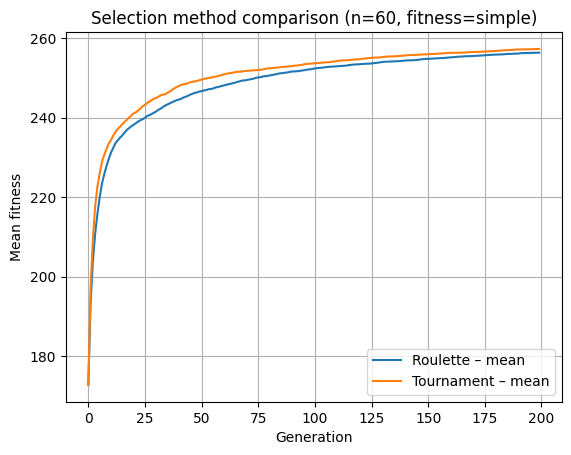

In [39]:
# مقادیر قسمت ح بر اساس بهترین تنظیم
n = 60
weights, values = load_knapsack_dataset(n)
capacity = capacities[n]

best_pop_size = 200
best_gens     = 200
best_Pc       = 0.9
best_Pm       = 0.1
f_type        = 'simple'

res_roulette = run_ea_knapsack_sel_cx(
    weights, values, capacity,
    pop_size=best_pop_size,
    max_generations=best_gens,
    Pc=best_Pc,
    Pm=best_Pm,
    fitness_type=f_type,
    selection_method='roulette',
    random_seed=0
)

res_tourn = run_ea_knapsack_sel_cx(
    weights, values, capacity,
    pop_size=best_pop_size,
    max_generations=best_gens,
    Pc=best_Pc,
    Pm=best_Pm,
    fitness_type=f_type,
    selection_method='tournament',
    tournament_k=2,
    random_seed=0
)

# رسم روی یک نمودار برای مقایسه‌ی میانگین برازندگی
gens = np.arange(best_gens)
plt.figure()
plt.plot(gens, res_roulette["mean_history"], label='Roulette – mean')
plt.plot(gens, res_tourn["mean_history"], label='Tournament – mean')
plt.xlabel("Generation")
plt.ylabel("Mean fitness")
plt.title(f"Selection method comparison (n={n}, fitness={f_type})")
plt.legend()
plt.grid(True)
plt.show()

### 10-
تقطیع یکنواخت

In [40]:
def uniform_crossover(parent_pool, Pc, swap_prob=0.5):
    pop_size, n = parent_pool.shape
    indices = np.arange(pop_size)
    np.random.shuffle(indices)
    shuffled = parent_pool[indices]

    offspring = []

    for i in range(0, pop_size, 2):
        p1 = shuffled[i]
        p2 = shuffled[(i + 1) % pop_size]
        if np.random.rand() < Pc:
            mask = np.random.rand(n) < swap_prob  # True : ژن از والد 1
            c1 = np.where(mask, p1, p2)
            c2 = np.where(mask, p2, p1)
        else:
            c1 = p1.copy()
            c2 = p2.copy()
        offspring.append(c1)
        offspring.append(c2)

    return np.array(offspring[:pop_size])

In [41]:
def run_ea_knapsack_full(weights, values, capacity,
                         pop_size=100,
                         max_generations=400,
                         Pc=0.8,
                         Pm=0.2,
                         fitness_type='simple',
                         ignore_capacity_for_full=True,
                         selection_method='roulette',  # یا 'tournament'
                         tournament_k=2,
                         crossover_method='single_point',  # یا 'uniform'
                         random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)
        random.seed(random_seed)

    n = len(weights)
    pop = np.random.randint(0, 2, size=(pop_size, n))

    best_history = []
    worst_history = []
    mean_history = []

    for gen in range(max_generations):
        fitnesses = evaluate_population(
            pop, weights, values, capacity,
            fitness_type,
            ignore_capacity_for_full=ignore_capacity_for_full
        )

        best_history.append(np.max(fitnesses))
        worst_history.append(np.min(fitnesses))
        mean_history.append(np.mean(fitnesses))

        # انتخاب
        if selection_method == 'roulette':
            parents = roulette_wheel_selection(pop, fitnesses, pop_size)
        elif selection_method == 'tournament':
            parents = tournament_selection(pop, fitnesses, pop_size, k=tournament_k)
        else:
            raise ValueError("Unknown selection method")

        # بازترکیب
        if crossover_method == 'single_point':
            offspring = single_point_crossover(parents, Pc)
        elif crossover_method == 'uniform':
            offspring = uniform_crossover(parents, Pc, swap_prob=0.5)
        else:
            raise ValueError("Unknown crossover method")

        # جهش
        offspring = bit_flip_mutation(offspring, Pm)

        # انتخاب نسل بعد
        offspring_fit = evaluate_population(
            offspring, weights, values, capacity,
            fitness_type,
            ignore_capacity_for_full=ignore_capacity_for_full
        )

        combined_pop = np.vstack([pop, offspring])
        combined_fit = np.concatenate([fitnesses, offspring_fit])
        order = np.argsort(-combined_fit)
        pop = combined_pop[order[:pop_size]]

    final_fitnesses = evaluate_population(
        pop, weights, values, capacity,
        fitness_type,
        ignore_capacity_for_full=ignore_capacity_for_full
    )

    return {
        "best_history": np.array(best_history),
        "worst_history": np.array(worst_history),
        "mean_history": np.array(mean_history),
        "final_population": pop,
        "final_fitnesses": final_fitnesses
    }

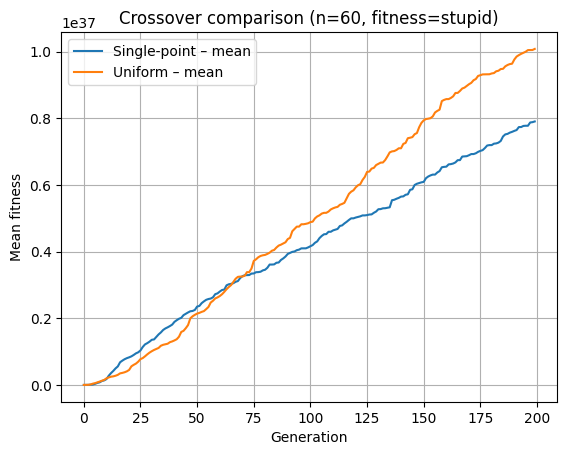

In [42]:
n = 60
weights, values = load_knapsack_dataset(n)
capacity = capacities[n]

best_pop_size = 200
best_gens     = 200
best_Pc       = 0.9
best_Pm       = 0.1
f_type        = 'stupid'

res_single = run_ea_knapsack_full(
    weights, values, capacity,
    pop_size=best_pop_size,
    max_generations=best_gens,
    Pc=best_Pc,
    Pm=best_Pm,
    fitness_type=f_type,
    selection_method='roulette',
    crossover_method='single_point',
    random_seed=0
)

res_uniform = run_ea_knapsack_full(
    weights, values, capacity,
    pop_size=best_pop_size,
    max_generations=best_gens,
    Pc=best_Pc,
    Pm=best_Pm,
    fitness_type=f_type,
    selection_method='roulette',
    crossover_method='uniform',
    random_seed=0
)

gens = np.arange(best_gens)
plt.figure()
plt.plot(gens, res_single["mean_history"], label='Single-point – mean')
plt.plot(gens, res_uniform["mean_history"], label='Uniform – mean')
plt.xlabel("Generation")
plt.ylabel("Mean fitness")
plt.title(f"Crossover comparison (n={n}, fitness={f_type})")
plt.legend()
plt.grid(True)
plt.show()

### Best?

In [45]:
import numpy as np
import pandas as pd
import random

# ظرفيت‌ها طبق تمرین
capacities = {10: 22, 20: 39, 60: 130, 100: 213}

def load_knapsack_dataset(n):
    df = pd.read_csv(f"knapsack_dataset_n{n}.csv")
    weights = df["Weight"].to_numpy(dtype=float)
    values  = df["Value"].to_numpy(dtype=float)
    return weights, values


def fitness_simple(x, weights, values, capacity, enforce_capacity=True):
    total_weight = float(np.dot(x, weights))
    total_value  = float(np.dot(x, values))
    if enforce_capacity and total_weight > capacity:
        return 0.0
    return total_value

def fitness_full(x, weights, values, capacity, enforce_capacity=True):
    selected_values = [v for xi, v in zip(x, values) if xi == 1]
    if not selected_values:
        return 0.0
    if enforce_capacity:
        total_weight = float(np.dot(x, weights))
        if total_weight > capacity:
            return 0.0
    prod = 1.0
    for v in selected_values:
        prod *= v
    return prod

def fitness_stupid(x, weights, values, capacity, enforce_capacity=True):
    n = len(x)
    total_weight = float(np.dot(x, weights))
    total_value  = float(np.dot(x, values))
    if enforce_capacity and total_weight > capacity:
        return 0.0
    selected_values = [v for xi, v in zip(x, values) if xi == 1]
    if not selected_values:
        return 0.0
    prod = 1.0
    for v in selected_values:
        prod *= v
    return (n**2) * prod - total_value


def evaluate_population(pop, weights, values, capacity,
                        fitness_type, ignore_capacity_for_full=True):
    fits = []
    for x in pop:
        if fitness_type == "simple":
            f = fitness_simple(x, weights, values, capacity, enforce_capacity=True)
        elif fitness_type == "full":
            enforce = not ignore_capacity_for_full   # در تمرین معمولاً False
            f = fitness_full(x, weights, values, capacity, enforce_capacity=enforce)
        elif fitness_type == "stupid":
            f = fitness_stupid(x, weights, values, capacity, enforce_capacity=True)
        else:
            raise ValueError("unknown fitness type")
        fits.append(f)
    return np.array(fits, dtype=float)


def roulette_wheel_selection(pop, fitnesses, num_selected):
    pop_size = len(pop)
    total_fit = float(np.sum(fitnesses))
    if total_fit <= 0:
        idx = np.random.randint(0, pop_size, size=num_selected)
        return pop[idx].copy()

    probs = fitnesses / total_fit
    cum_probs = np.cumsum(probs)
    selected = []
    for _ in range(num_selected):
        r = np.random.rand()
        idx = np.searchsorted(cum_probs, r)
        selected.append(pop[idx].copy())
    return np.array(selected)

def single_point_crossover(parent_pool, Pc):
    pop_size, n = parent_pool.shape
    indices = np.arange(pop_size)
    np.random.shuffle(indices)
    shuffled = parent_pool[indices]

    children = []
    for i in range(0, pop_size, 2):
        p1 = shuffled[i]
        p2 = shuffled[(i + 1) % pop_size]
        if np.random.rand() < Pc:
            cp = np.random.randint(1, n)
            c1 = np.concatenate([p1[:cp], p2[cp:]])
            c2 = np.concatenate([p2[:cp], p1[cp:]])
        else:
            c1 = p1.copy()
            c2 = p2.copy()
        children.append(c1)
        children.append(c2)
    return np.array(children[:pop_size])

def bit_flip_mutation(offspring, Pm):
    pop_size, n = offspring.shape
    for i in range(pop_size):
        for j in range(n):
            if np.random.rand() < Pm:
                offspring[i, j] = 1 - offspring[i, j]
    return offspring

def run_ea_knapsack(weights, values, capacity,
                    pop_size=100,
                    max_generations=400,
                    Pc=0.8,
                    Pm=0.2,
                    fitness_type="simple",
                    ignore_capacity_for_full=True,
                    random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)
        random.seed(random_seed)

    n = len(weights)
    pop = np.random.randint(0, 2, size=(pop_size, n))

    best_history = []
    worst_history = []
    mean_history = []

    for gen in range(max_generations):
        fits = evaluate_population(pop, weights, values, capacity,
                                   fitness_type, ignore_capacity_for_full)

        best_history.append(float(np.max(fits)))
        worst_history.append(float(np.min(fits)))
        mean_history.append(float(np.mean(fits)))

        # انتخاب والد
        parents = roulette_wheel_selection(pop, fits, pop.shape[0])
        # بازترکیب تک‌نقطه‌ای
        offspring = single_point_crossover(parents, Pc)
        # جهش
        offspring = bit_flip_mutation(offspring, Pm)

        # ارزیابی فرزندان
        off_fits = evaluate_population(offspring, weights, values, capacity,
                                       fitness_type, ignore_capacity_for_full)

        # انتخاب elitist از pop + offspring
        combined_pop = np.vstack([pop, offspring])
        combined_fit = np.concatenate([fits, off_fits])
        order = np.argsort(-combined_fit)
        pop = combined_pop[order[:pop_size]]

    final_fits = evaluate_population(pop, weights, values, capacity,
                                     fitness_type, ignore_capacity_for_full)

    return {
        "best_history": np.array(best_history),
        "worst_history": np.array(worst_history),
        "mean_history": np.array(mean_history),
        "final_population": pop,
        "final_fitnesses": final_fits
    }

def show_best_solution(result, weights, values, capacity,
                       fitness_type="simple",
                       ignore_capacity_for_full=True):
    final_pop = result["final_population"]
    final_fit = result["final_fitnesses"]

    idx_best = int(np.argmax(final_fit))
    x_best = final_pop[idx_best]
    fit_best = float(final_fit[idx_best])

    total_weight = float(np.dot(x_best, weights))
    total_value  = float(np.dot(x_best, values))

    # برای کنترل:
    check_fit = evaluate_population(
        np.array([x_best]),
        weights,
        values,
        capacity,
        fitness_type,
        ignore_capacity_for_full
    )[0]

    info = {
        "chromosome": "".join(str(int(b)) for b in x_best),
        "total_weight": total_weight,
        "total_value": total_value,
        "fitness": fit_best,
        "recomputed": float(check_fit)
    }
    return info

In [46]:
def format_chromosome(chrom, group=10):
    # برای خواناتر شدن، هر 10 بیت یک فاصله می‌گذاریم
    return " ".join(chrom[i:i+group] for i in range(0, len(chrom), group))

fitness_types = ["simple", "full", "stupid"]

rows = []
for n in (10, 20, 60, 100):
    weights, values = load_knapsack_dataset(n)
    capacity = capacities[n]

    for f_type in fitness_types:
        res = run_ea_knapsack(
            weights, values, capacity,
            pop_size=100,
            max_generations=400,
            Pc=0.8,
            Pm=0.2,
            fitness_type=f_type,
            ignore_capacity_for_full=True,
            random_seed=0
        )
        info = show_best_solution(res, weights, values, capacity,
                                  fitness_type=f_type,
                                  ignore_capacity_for_full=True)
        rows.append((n, f_type,
                     format_chromosome(info["chromosome"]),
                     int(info["total_weight"]),
                     int(info["total_value"]),
                     info["fitness"]))

print("| n | fitness_type | chromosome (grouped by 10 bits) | total_weight | total_value | best_fitness |")
print("|---|--------------|-----------------------------------|-------------|------------|-------------|")
for n, ftype, chrom, w, v, fit in rows:
    print(f"| {n} | {ftype} | `{chrom}` | {w} | {v} | {fit:.3g} |")

| n | fitness_type | chromosome (grouped by 10 bits) | total_weight | total_value | best_fitness |
|---|--------------|-----------------------------------|-------------|------------|-------------|
| 10 | simple | `1111111101` | 22 | 39 | 39 |
| 10 | full | `1111111111` | 24 | 42 | 4.84e+05 |
| 10 | stupid | `1111111101` | 22 | 39 | 1.61e+07 |
| 20 | simple | `1101111111 1110001101` | 39 | 85 | 85 |
| 20 | full | `1111111111 1111111111` | 57 | 109 | 1.2e+14 |
| 20 | stupid | `1111011110 1110011111` | 39 | 81 | 2.08e+13 |
| 60 | simple | `1111011111 1110110110 0110100110 1110111101 0010111110 1111111111` | 130 | 254 | 254 |
| 60 | full | `1011111111 1111111110 1111111111 1111111110 1111111111 1111111111` | 181 | 325 | 5.28e+41 |
| 60 | stupid | `1110011111 0110111111 1111111010 1111111111 0010111011 1010010111` | 130 | 257 | 3.93e+36 |
| 100 | simple | `1011111011 1011111011 1101110111 1111111101 1001011111 0001100101 1111111100 1100011011 1001110111 0111101111` | 213 | 410 | 410 |
| 100

In [47]:
# ==========================
#  0) Imports & basic config
# ==========================
import numpy as np
import pandas as pd
import random

# Problem capacities for each dataset size
CAPACITIES = {10: 22, 20: 39, 60: 130, 100: 213}

# Number of independent runs per configuration (for stochastic EA)
RUNS = 6   # حداقل

# =====================
#  1) Load dataset
# =====================
def load_knapsack_dataset(n, base_path=""):
    """
    Reads knapsack_dataset_n{n}.csv and returns (weights, values).
    CSV must have columns: 'Weight', 'Value'.
    """
    df = pd.read_csv(f"{base_path}knapsack_dataset_n{n}.csv")
    weights = df["Weight"].to_numpy(dtype=float)
    values  = df["Value"].to_numpy(dtype=float)
    return weights, values

# =====================
#  2) Fitness functions
# =====================
def fitness_simple(x, weights, values, capacity, enforce_capacity=True):
    total_weight = float(np.dot(x, weights))
    total_value  = float(np.dot(x, values))
    if enforce_capacity and total_weight > capacity:
        return 0.0
    return total_value

def fitness_full(x, weights, values, capacity, enforce_capacity=True):
    selected_values = [v for xi, v in zip(x, values) if xi == 1]
    if not selected_values:
        return 0.0
    if enforce_capacity:
        total_weight = float(np.dot(x, weights))
        if total_weight > capacity:
            return 0.0
    prod = 1.0
    for v in selected_values:
        prod *= v
    return prod

def fitness_stupid(x, weights, values, capacity, enforce_capacity=True):
    n = len(x)
    total_weight = float(np.dot(x, weights))
    total_value  = float(np.dot(x, values))
    if enforce_capacity and total_weight > capacity:
        return 0.0
    selected_values = [v for xi, v in zip(x, values) if xi == 1]
    if not selected_values:
        return 0.0
    prod = 1.0
    for v in selected_values:
        prod *= v
    return (n ** 2) * prod - total_value

def evaluate_population(pop, weights, values, capacity,
                        fitness_type, ignore_capacity_for_full=True):
    fits = []
    for x in pop:
        if fitness_type == "simple":
            f = fitness_simple(x, weights, values, capacity,
                               enforce_capacity=True)
        elif fitness_type == "full":
            enforce = not ignore_capacity_for_full
            f = fitness_full(x, weights, values, capacity,
                             enforce_capacity=enforce)
        elif fitness_type == "stupid":
            f = fitness_stupid(x, weights, values, capacity,
                               enforce_capacity=True)
        else:
            raise ValueError("Unknown fitness_type")
        fits.append(f)
    return np.array(fits, dtype=float)

# ======================
#  3) Selection, Cx, Mut
# ======================
def roulette_wheel_selection(pop, fitnesses, num_selected):
    pop_size = len(pop)
    total_fit = float(np.sum(fitnesses))
    if total_fit <= 0:
        idx = np.random.randint(0, pop_size, size=num_selected)
        return pop[idx].copy()

    probs = fitnesses / total_fit
    cum_probs = np.cumsum(probs)
    selected = []
    for _ in range(num_selected):
        r = np.random.rand()
        idx = np.searchsorted(cum_probs, r)
        selected.append(pop[idx].copy())
    return np.array(selected)

def single_point_crossover(parent_pool, Pc):
    pop_size, n = parent_pool.shape
    indices = np.arange(pop_size)
    np.random.shuffle(indices)
    shuffled = parent_pool[indices]

    children = []
    for i in range(0, pop_size, 2):
        p1 = shuffled[i]
        p2 = shuffled[(i + 1) % pop_size]
        if np.random.rand() < Pc:
            cp = np.random.randint(1, n)  # cut point in [1, n-1]
            c1 = np.concatenate([p1[:cp], p2[cp:]])
            c2 = np.concatenate([p2[:cp], p1[cp:]])
        else:
            c1 = p1.copy()
            c2 = p2.copy()
        children.append(c1)
        children.append(c2)
    return np.array(children[:pop_size])

def bit_flip_mutation(offspring, Pm):
    pop_size, n = offspring.shape
    for i in range(pop_size):
        for j in range(n):
            if np.random.rand() < Pm:
                offspring[i, j] = 1 - offspring[i, j]
    return offspring

# =====================
#  4) Main EA function
# =====================
def run_ea_knapsack(weights, values, capacity,
                    pop_size=100,
                    max_generations=400,
                    Pc=0.8,
                    Pm=0.2,
                    fitness_type="simple",
                    ignore_capacity_for_full=True,
                    random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)
        random.seed(random_seed)

    n = len(weights)
    pop = np.random.randint(0, 2, size=(pop_size, n))

    best_history = []
    worst_history = []
    mean_history = []

    for gen in range(max_generations):
        fits = evaluate_population(pop, weights, values, capacity,
                                   fitness_type,
                                   ignore_capacity_for_full)

        best_history.append(float(np.max(fits)))
        worst_history.append(float(np.min(fits)))
        mean_history.append(float(np.mean(fits)))

        parents = roulette_wheel_selection(pop, fits, pop.shape[0])
        offspring = single_point_crossover(parents, Pc)
        offspring = bit_flip_mutation(offspring, Pm)

        off_fits = evaluate_population(offspring, weights, values, capacity,
                                       fitness_type,
                                       ignore_capacity_for_full)

        combined_pop = np.vstack([pop, offspring])
        combined_fit = np.concatenate([fits, off_fits])
        order = np.argsort(-combined_fit)
        pop = combined_pop[order[:pop_size]]

    final_fits = evaluate_population(pop, weights, values, capacity,
                                     fitness_type,
                                     ignore_capacity_for_full)

    return {
        "best_history": np.array(best_history),
        "worst_history": np.array(worst_history),
        "mean_history": np.array(mean_history),
        "final_population": pop,
        "final_fitnesses": final_fits,
    }

# ==========================
#  5) Best solution extractor
# ==========================
def get_best_solution_from_result(result, weights, values, capacity,
                                  fitness_type="simple",
                                  ignore_capacity_for_full=True):
    final_pop = result["final_population"]
    final_fit = result["final_fitnesses"]

    idx_best = int(np.argmax(final_fit))
    x_best = final_pop[idx_best]
    fit_best = float(final_fit[idx_best])

    total_weight = float(np.dot(x_best, weights))
    total_value  = float(np.dot(x_best, values))

    # recompute fitness for sanity check
    check_fit = evaluate_population(
        np.array([x_best]),
        weights,
        values,
        capacity,
        fitness_type,
        ignore_capacity_for_full
    )[0]

    return {
        "chromosome": "".join(str(int(b)) for b in x_best),
        "total_weight": total_weight,
        "total_value": total_value,
        "fitness": fit_best,
        "fitness_recomputed": float(check_fit),
    }

def format_chromosome(chrom, group=10):
    return " ".join(chrom[i:i+group] for i in range(0, len(chrom), group))

# ============================================
#  6) Define all configurations for questions
# ============================================

fitness_types = ["simple", "full", "stupid"]

# پایه (سوال الف/ب: n=10 با پارامترهای ثابت)
BASE_CONFIGS = [
    {
        "question": "base_n10",
        "n": 10,
        "pop_size": 100,
        "max_generations": 400,
        "Pc": 0.8,
        "Pm": 0.2,
    }
]

# پ) تاثیر اندازه مسئله (n) – بقیه پارامترها ثابت
P_CONFIGS = []
for n in (10, 20, 60, 100):
    P_CONFIGS.append({
        "question": "p_problem_size",
        "n": n,
        "pop_size": 100,
        "max_generations": 400,
        "Pc": 0.8,
        "Pm": 0.2,
    })

# ت) تاثیر تعداد نسل‌ها
T_CONFIGS = []
for n in (10, 20, 60, 100):
    for gens in (50, 100, 200, 300):
        T_CONFIGS.append({
            "question": "t_generations",
            "n": n,
            "pop_size": 100,
            "max_generations": gens,
            "Pc": 0.8,
            "Pm": 0.2,
        })

# ث) تاثیر اندازه جمعیت
TH_CONFIGS = []
for n in (10, 20, 60, 100):
    for pop_size in (50, 100, 200, 300):
        TH_CONFIGS.append({
            "question": "th_population",
            "n": n,
            "pop_size": pop_size,
            "max_generations": 400,
            "Pc": 0.8,
            "Pm": 0.2,
        })

# ج) تاثیر Pc
J_CONFIGS = []
for n in (10, 20, 60, 100):
    for Pc in (0.6, 0.7, 0.9, 1.0):
        J_CONFIGS.append({
            "question": "j_crossover_prob",
            "n": n,
            "pop_size": 100,
            "max_generations": 400,
            "Pc": Pc,
            "Pm": 0.2,
        })

# چ) تاثیر Pm
CH_CONFIGS = []
for n in (10, 20, 60, 100):
    for Pm in (0.05, 0.1, 0.3, 0.5):
        CH_CONFIGS.append({
            "question": "ch_mutation_prob",
            "n": n,
            "pop_size": 100,
            "max_generations": 400,
            "Pc": 0.8,
            "Pm": Pm,
        })

ALL_CONFIGS = (
    BASE_CONFIGS +
    P_CONFIGS +
    T_CONFIGS +
    TH_CONFIGS +
    J_CONFIGS +
    CH_CONFIGS
)

# ===========================================
#  7) Run ALL configurations & collect bests
# ===========================================
best_rows = []

for cfg_idx, cfg in enumerate(ALL_CONFIGS, start=1):
    n = cfg["n"]
    pop_size = cfg["pop_size"]
    max_gen = cfg["max_generations"]
    Pc = cfg["Pc"]
    Pm = cfg["Pm"]
    question_label = cfg["question"]

    print(f"Config {cfg_idx}/{len(ALL_CONFIGS)}:",
          f"Q={question_label}, n={n}, pop={pop_size}, gens={max_gen}, Pc={Pc}, Pm={Pm}")

    weights, values = load_knapsack_dataset(n)
    capacity = CAPACITIES[n]

    for f_type in fitness_types:
        # برای هر ترکیب، چند اجرا انجام می‌دهیم و بهترین بین همه‌ی اجراها را نگه می‌داریم
        best_overall = None

        for run in range(RUNS):
            res = run_ea_knapsack(
                weights, values, capacity,
                pop_size=pop_size,
                max_generations=max_gen,
                Pc=Pc,
                Pm=Pm,
                fitness_type=f_type,
                ignore_capacity_for_full=True,  # Full بدون قید
                random_seed=run  # برای تکرارپذیری
            )

            info = get_best_solution_from_result(
                res, weights, values, capacity,
                fitness_type=f_type,
                ignore_capacity_for_full=True
            )

            if (best_overall is None) or (info["fitness"] > best_overall["fitness"]):
                best_overall = info
                best_overall["run"] = run

        # بعد از پایان RUNS، best_overall بهترین جواب این ترکیب است
        best_rows.append({
            "question": question_label,
            "n": n,
            "fitness_type": f_type,
            "pop_size": pop_size,
            "max_generations": max_gen,
            "Pc": Pc,
            "Pm": Pm,
            "best_run_index": best_overall["run"],
            "chromosome": format_chromosome(best_overall["chromosome"], group=10),
            "total_weight": best_overall["total_weight"],
            "total_value": best_overall["total_value"],
            "best_fitness": best_overall["fitness"],
        })

# تبدیل به DataFrame
best_df = pd.DataFrame(best_rows)

# نمایش چند سطر اول
best_df.head()

Config 1/69: Q=base_n10, n=10, pop=100, gens=400, Pc=0.8, Pm=0.2
Config 2/69: Q=p_problem_size, n=10, pop=100, gens=400, Pc=0.8, Pm=0.2
Config 3/69: Q=p_problem_size, n=20, pop=100, gens=400, Pc=0.8, Pm=0.2
Config 4/69: Q=p_problem_size, n=60, pop=100, gens=400, Pc=0.8, Pm=0.2
Config 5/69: Q=p_problem_size, n=100, pop=100, gens=400, Pc=0.8, Pm=0.2
Config 6/69: Q=t_generations, n=10, pop=100, gens=50, Pc=0.8, Pm=0.2
Config 7/69: Q=t_generations, n=10, pop=100, gens=100, Pc=0.8, Pm=0.2
Config 8/69: Q=t_generations, n=10, pop=100, gens=200, Pc=0.8, Pm=0.2
Config 9/69: Q=t_generations, n=10, pop=100, gens=300, Pc=0.8, Pm=0.2
Config 10/69: Q=t_generations, n=20, pop=100, gens=50, Pc=0.8, Pm=0.2
Config 11/69: Q=t_generations, n=20, pop=100, gens=100, Pc=0.8, Pm=0.2
Config 12/69: Q=t_generations, n=20, pop=100, gens=200, Pc=0.8, Pm=0.2
Config 13/69: Q=t_generations, n=20, pop=100, gens=300, Pc=0.8, Pm=0.2
Config 14/69: Q=t_generations, n=60, pop=100, gens=50, Pc=0.8, Pm=0.2
Config 15/69: Q=t_

,question,n,fitness_type,pop_size,max_generations,Pc,Pm,best_run_index,chromosome,total_weight,total_value,best_fitness
0,base_n10,10,simple,100,400,0.8,0.2,0,1111111101,22.0,39.0,39.0
1,base_n10,10,full,100,400,0.8,0.2,0,1111111111,24.0,42.0,483840.0
2,base_n10,10,stupid,100,400,0.8,0.2,0,1111111101,22.0,39.0,16127961.0
3,p_problem_size,10,simple,100,400,0.8,0.2,0,1111111101,22.0,39.0,39.0
4,p_problem_size,10,full,100,400,0.8,0.2,0,1111111111,24.0,42.0,483840.0


In [48]:
best_df.to_csv("EA_knapsack_all_best_solutions.csv", index=False)
print("Saved to EA_knapsack_all_best_solutions.csv")

Saved to EA_knapsack_all_best_solutions.csv
